In [537]:
import os
import urllib.request

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dbfread import DBF
from IPython.display import display
from ipywidgets import Output, RadioButtons, interact, widgets
from matplotlib import widgets
from matplotlib.widgets import RadioButtons
from ortools.linear_solver import pywraplp
from pandas import DataFrame

# Wind turbine optimization

## 0 - Importing data

In [538]:
"""
Load content of a DBF file into a Pandas data frame.

The iter() is required because Pandas doesn't detect that the DBF
object is iterable.

Loading the raw geospatial data into a Pandas data frame.

Datasource: https://www.swisstopo.admin.ch/en/home/meta/supply-structure/freely-available.html
"""

# Downloading a file from remote to a local file in a folder called Geospatial_raw_data_remote
dbf_url = 'https://github.com/percw/Swiss_wind-turbine_optimization/raw/b23d047c6f824bb225cc1b7d5aa559166f191ec6/Geospatial_raw_data/spat_pts/spat_pts.dbf'
shape_url = 'https://github.com/percw/Swiss_wind-turbine_optimization/raw/b23d047c6f824bb225cc1b7d5aa559166f191ec6/Geospatial_raw_data/spat_pts/spat_pts.shp'


# Checking if the folder Geospatial_raw_data exists, if not: downloading the files from remote
if not os.path.exists('./Geospatial_raw_data/'):
	os.makedirs('./Geospatial_raw_data/spat_pts/')
	urllib.request.urlretrieve(dbf_url, './Geospatial_raw_data/spat_pts.dbf') 		# Loading the .dbf file
	urllib.request.urlretrieve(shape_url, './Geospatial_raw_data/spat_pts.shp') 	# Loading the .shp file

# Loading the file from local to Geopandas and Pandas data frame
dbf = DBF('./Geospatial_raw_data/spat_pts.dbf', encoding='UTF-8')
gdf = gpd.read_file('./Geospatial_raw_data/spat_pts.shp')
df_dbf_raw = DataFrame(iter(dbf))



File: `spat_pts.dbf` - consists of candidate wind turbine locations in Switzerland which are technically feasible. The readme file provides details about the 30 attributes further attributes and the coordinate reference system. 

In [539]:
print(df_dbf_raw.head(10))
#print(df_shp_raw.head(10))

# Displaying the column names of the dbf file
print(df_dbf_raw.columns)

    PU_ID   LT  WT_ID  DIST_ISOS  DIST_UNE_N  DIST_UNE_K  DIST_BLN  DIST_VAEW  \
0   738.0  1.0    9.0      735.0    132448.0     16505.0     184.0   115789.0   
1   880.0  1.0   11.0      567.0    132177.0     16475.0     382.0   115340.0   
2   881.0  1.0   12.0      186.0    131844.0     15740.0     156.0   115343.0   
3  1021.0  1.0   15.0      424.0    131912.0     16340.0     389.0   114896.0   
4  1163.0  1.0   20.0     1288.0    131652.0     16255.0     349.0   114458.0   
5  1449.0  1.0   24.0      767.0    130084.0     14166.0     412.0   113543.0   
6  1586.0  1.0   25.0      940.0    131307.0     17251.0     650.0   113249.0   
7  1589.0  1.0   28.0     1856.0    130159.0     14700.0     223.0   113097.0   
8  1590.0  1.0   29.0      636.0    129811.0     14094.0     387.0   113089.0   
9  1591.0  1.0   30.0      847.0    129481.0     13388.0     225.0   113102.0   

   DIST_RAD  DIST_AIR  ...  COHER_AREA  VIS_ARE_ha  ENER_DENS     DIST_NATPA  \
0   26065.0    2861.0  ...  

## 1 - Discovering the data 

In [540]:

print(f'Number of technically possible wind turbine locations: {len(df_dbf_raw["PU_ID"].unique())}')
print(f'Number of canton where its feasible to place wind turbine: {len(df_dbf_raw["CANT_NAME"].unique())}')
print(f'The cantons are: {df_dbf_raw["CANT_NAME"].unique()}')

Number of technically possible wind turbine locations: 12238
Number of canton where its feasible to place wind turbine: 27
The cantons are: ['GenÃ¨ve' 'Vaud' 'NeuchÃ¢tel' 'Fribourg' 'Valais' 'Bern' 'Jura'
 'Solothurn' 'Basel-Landschaft' 'Basel-Stadt' 'Aargau' 'Luzern' 'Obwalden'
 'Nidwalden' 'ZÃ¼rich' 'Zug' 'Schaffhausen' 'Schwyz' 'Uri' 'Thurgau'
 'Ticino' 'St. Gallen' 'Glarus' 'GraubÃ¼nden' 'Appenzell Ausserrhoden'
 'Appenzell Innerrhoden' '']


Checking out the canton with the empty string

In [541]:
display(df_dbf_raw[df_dbf_raw["CANT_NAME"] == ''])

,PU_ID,LT,WT_ID,DIST_ISOS,DIST_UNE_N,DIST_UNE_K,DIST_BLN,DIST_VAEW,DIST_RAD,DIST_AIR,...,COHER_AREA,VIS_ARE_ha,ENER_DENS,DIST_NATPA,STRE_ALTI,DIST_REG_N,weigh_stre,prod_MW,KIBK,CANT_NAME
11483,44486.0,3.0,90016.0,4448.0,103730.0,25509.0,1211.0,118303.0,110823.0,4602.0,...,0.060856,16516.0,0.17994,240473.993717,884.0,0.0,669.999901,8173.304396,4.0,


Investigating the shapefile

In [542]:
display(gdf.columns)
display(gdf.head())

Index(['PU_ID', 'LT', 'WT_ID', 'DIST_ISOS', 'DIST_UNE_N', 'DIST_UNE_K',
       'DIST_BLN', 'DIST_VAEW', 'DIST_RAD', 'DIST_AIR', 'DIST_MIL',
       'DIST_FLOOD', 'DIST_MEAD', 'DIST_JB', 'DIST_BIOS', 'DIST_STRE',
       'DIST_FOR', 'DIST_HZ', 'DIST_IZ', 'DIST_PL', 'DIST_BUILD', 'ALTI',
       'NOISE', 'FFF', 'VIS_AREA', 'VIS_IMPACT', 'VIS_INFRA', 'VIS_POP',
       'COHER_AREA', 'VIS_ARE_ha', 'ENER_DENS', 'DIST_NATPA', 'STRE_ALTI',
       'DIST_REG_N', 'weigh_stre', 'prod_MW', 'KIBK', 'CANT_NAME', 'geometry'],
      dtype='object')

,PU_ID,LT,WT_ID,DIST_ISOS,DIST_UNE_N,DIST_UNE_K,DIST_BLN,DIST_VAEW,DIST_RAD,DIST_AIR,...,VIS_ARE_ha,ENER_DENS,DIST_NATPA,STRE_ALTI,DIST_REG_N,weigh_stre,prod_MW,KIBK,CANT_NAME,geometry
0,738.0,1.0,9.0,735.0,132448.0,16505.0,184.0,115789.0,26065.0,2861.0,...,28132.0,0.405058,314835.059489,457.0,24717.649525,219.999966,11395.094829,4.0,GenÃ¨ve,POINT (487660.175 118136.448)
1,880.0,1.0,11.0,567.0,132177.0,16475.0,382.0,115340.0,26638.0,1965.0,...,29088.0,0.400389,314505.331052,455.0,25089.914492,111.000053,11646.518761,4.0,GenÃ¨ve,POINT (488110.175 117357.025)
2,881.0,1.0,12.0,186.0,131844.0,15740.0,156.0,115343.0,25176.0,3242.0,...,27704.0,0.397480,314276.488429,432.0,23823.745962,160.000017,11011.797909,2.0,GenÃ¨ve,POINT (488110.175 118915.871)
3,1021.0,1.0,15.0,424.0,131912.0,16340.0,389.0,114896.0,27229.0,1068.0,...,28600.0,0.395229,314177.833777,419.0,25488.529743,111.000031,11303.539758,1.0,GenÃ¨ve,POINT (488560.175 116577.603)
4,1163.0,1.0,20.0,1288.0,131652.0,16255.0,349.0,114458.0,27836.0,171.0,...,28680.0,0.417131,313852.574631,377.0,25912.279012,785.999983,11963.309177,3.0,GenÃ¨ve,POINT (489010.175 115798.180)


## 2 - Visualisation

First plot of the potential.

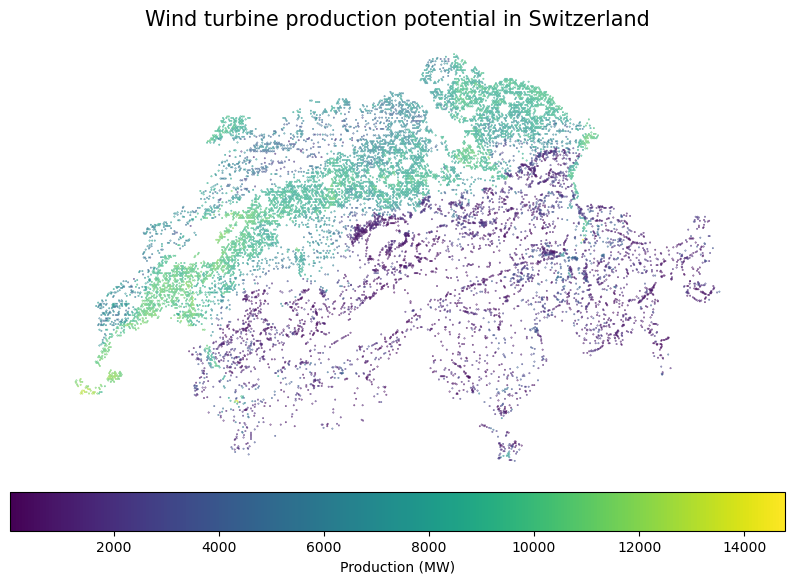

In [543]:
fig, ax = plt.subplots(figsize=(10, 7))

markersize = 0.1

gdf.plot(column='prod_MW', ax=ax, markersize=markersize, cmap='viridis', legend=True, legend_kwds={
    'label': "Production (MW)", 'orientation': "horizontal", 'pad': 0.02})
ax.set_axis_off()

fig.savefig("wind_turbine_production.png")  # Save the graph as PNG

# Adding title to the plot
ax.set_title('Wind turbine production potential in Switzerland', fontdict={'fontsize': '15', 'fontweight': '3'})
plt.show()

Let's check the distribution of the potential.

Number of missing values in 'prod_MW' column:  0
68190356.77669612


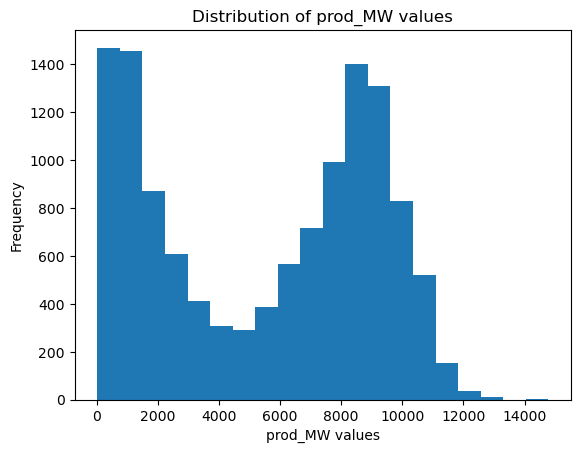

,PU_ID,LT,WT_ID,DIST_ISOS,DIST_UNE_N,DIST_UNE_K,DIST_BLN,DIST_VAEW,DIST_RAD,DIST_AIR,...,VIS_ARE_ha,ENER_DENS,DIST_NATPA,STRE_ALTI,DIST_REG_N,weigh_stre,prod_MW,KIBK,CANT_NAME,geometry
6530,98979.0,2.0,17402.0,5189.0,37961.0,24689.0,4001.0,44527.0,33719.0,5906.0,...,1920.0,0.151118,216914.383017,888.0,0.000000,295.000424,64.369422,4.0,Fribourg,POINT (582160.175 161437.719)
7335,164142.0,2.0,34207.0,5761.0,6249.0,43014.0,0.0,24413.0,54885.0,7378.0,...,2396.0,0.090399,153238.301602,591.0,10874.128571,18602.001196,51.867107,3.0,Bern,POINT (645910.175 170530.985)
7502,171819.0,2.0,36686.0,1226.0,10685.0,30202.0,4444.0,36307.0,63121.0,3483.0,...,2476.0,0.070395,146374.453576,753.0,6336.134207,402.000092,34.264004,4.0,Obwalden,POINT (653410.175 180923.290)
7710,183064.0,2.0,39537.0,8129.0,15217.0,23131.0,10135.0,43041.0,56623.0,9059.0,...,2556.0,0.153470,135701.574533,1068.0,16633.287189,531.999239,87.460948,4.0,Obwalden,POINT (664410.175 183521.366)
7830,190176.0,2.0,41066.0,5787.0,10565.0,58657.0,7566.0,8795.0,59848.0,5425.0,...,1848.0,0.102058,128839.010903,1991.0,8788.463574,272.999753,33.449275,5.0,Valais,POINT (671410.175 147148.299)
7955,199347.0,2.0,43223.0,2618.0,33570.0,41852.0,8714.0,18360.0,36543.0,26921.0,...,1772.0,0.200754,125399.294705,1367.0,18345.247060,5247.999921,78.928263,5.0,Ticino,POINT (680410.175 123765.613)
7970,200433.0,2.0,43601.0,9580.0,24647.0,28782.0,10249.0,34911.0,58407.0,12444.0,...,1400.0,0.194483,118335.375082,1623.0,32700.637529,3169.999994,81.826701,3.0,Uri,POINT (681410.175 179191.239)
7985,201670.0,2.0,43952.0,6963.0,20302.0,47559.0,0.0,16040.0,51069.0,13040.0,...,2752.0,0.147843,118181.261022,974.0,16041.928363,12934.000269,92.628498,3.0,Ticino,POINT (682660.175 144117.210)
8094,209578.0,2.0,46483.0,728.0,33491.0,35299.0,1215.0,23118.0,37852.0,16913.0,...,3536.0,0.110428,113028.488765,488.0,23107.392109,160.998678,87.080944,1.0,Ticino,POINT (690410.175 133291.893)
8608,232660.0,2.0,55194.0,10405.0,11986.0,23229.0,671.0,22102.0,42946.0,9033.0,...,2132.0,0.121073,95420.457388,1059.0,36481.968840,2667.999830,66.636473,4.0,Glarus,POINT (712910.175 208636.103)


,PU_ID,LT,WT_ID,DIST_ISOS,DIST_UNE_N,DIST_UNE_K,DIST_BLN,DIST_VAEW,DIST_RAD,DIST_AIR,...,VIS_POP,COHER_AREA,VIS_ARE_ha,ENER_DENS,DIST_NATPA,STRE_ALTI,DIST_REG_N,weigh_stre,prod_MW,KIBK
count,12337.000000,12337.000000,12337.000000,12337.000000,12337.000000,12337.000000,12337.000000,12337.000000,12337.000000,12337.000000,...,12337.000000,12337.000000,1.233700e+04,12337.000000,12337.000000,12337.000000,12337.000000,12337.000000,12337.000000,12337.000000
mean,116349.752128,1.611089,33500.947232,3406.268218,50514.026911,16910.155386,4078.618303,63359.975034,54041.234903,7730.363541,...,0.085634,0.106215,4.992939e+04,0.467271,153394.586907,800.200292,16598.669576,2552.309680,5527.304594,3.257923
std,95026.183979,0.677602,32583.579612,2556.684231,27953.949662,14354.993450,3897.662500,28636.751827,26695.421180,6445.073959,...,0.115575,0.063763,8.267178e+05,0.386191,70545.210711,403.457574,15124.306648,4154.501028,3613.139910,1.485863
min,738.000000,1.000000,9.000000,34.000000,0.000000,0.000000,0.000000,0.000000,5000.000000,0.000000,...,0.000000,0.004784,5.880000e+02,0.000062,0.000000,197.000000,0.000000,50.000046,26.259217,0.000000
25%,44400.000000,1.000000,6057.000000,1617.000000,29817.000000,6937.000000,894.000000,42241.000000,34435.000000,3261.000000,...,0.005326,0.050102,6.612000e+03,0.238602,104185.618569,500.000000,4766.412624,304.000090,1622.599642,1.000000
50%,71977.000000,2.000000,12468.000000,2753.000000,50671.000000,13347.000000,3071.000000,66702.000000,51972.000000,6323.000000,...,0.047868,0.090905,1.682800e+04,0.323510,153431.937572,655.000000,12709.049391,674.000632,6439.760512,4.000000
75%,194081.000000,2.000000,65058.000000,4450.000000,68770.000000,22499.000000,6116.000000,84543.000000,69188.000000,10513.000000,...,0.127433,0.157120,3.172400e+04,0.578401,209893.720869,993.000000,24616.642686,2223.999946,8763.373718,4.000000
max,356018.000000,3.000000,91889.000000,20604.000000,132448.000000,91039.000000,19832.000000,135204.000000,152836.000000,51176.000000,...,1.769340,0.444749,2.308970e+07,5.175410,314835.059489,2474.000000,72851.185941,25749.996809,14775.569813,5.000000


In [544]:
missing_values = gdf['prod_MW'].isnull().sum()
print("Number of missing values in 'prod_MW' column: ", missing_values)

total_value = gdf['prod_MW'].sum()
print(total_value)

len(gdf)


# Extract the values from the prod_MW column
prod_MW_values = gdf['prod_MW'].values

# Create a histogram of the prod_MW values
plt.hist(prod_MW_values, bins=20)

# Add a title and axis labels
plt.title('Distribution of prod_MW values')
plt.xlabel('prod_MW values')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Select the rows where prod_MW is 0
zero_prod_MW = gdf[gdf['prod_MW'] < 100]

# Display the selected rows
display(zero_prod_MW)

gdf.describe()

Creating subplot maps over the different columns to show how the different characteristics such as power, closest distance to nearest house etc for the technically plausible wind turbine locations in Switzerland looks like.

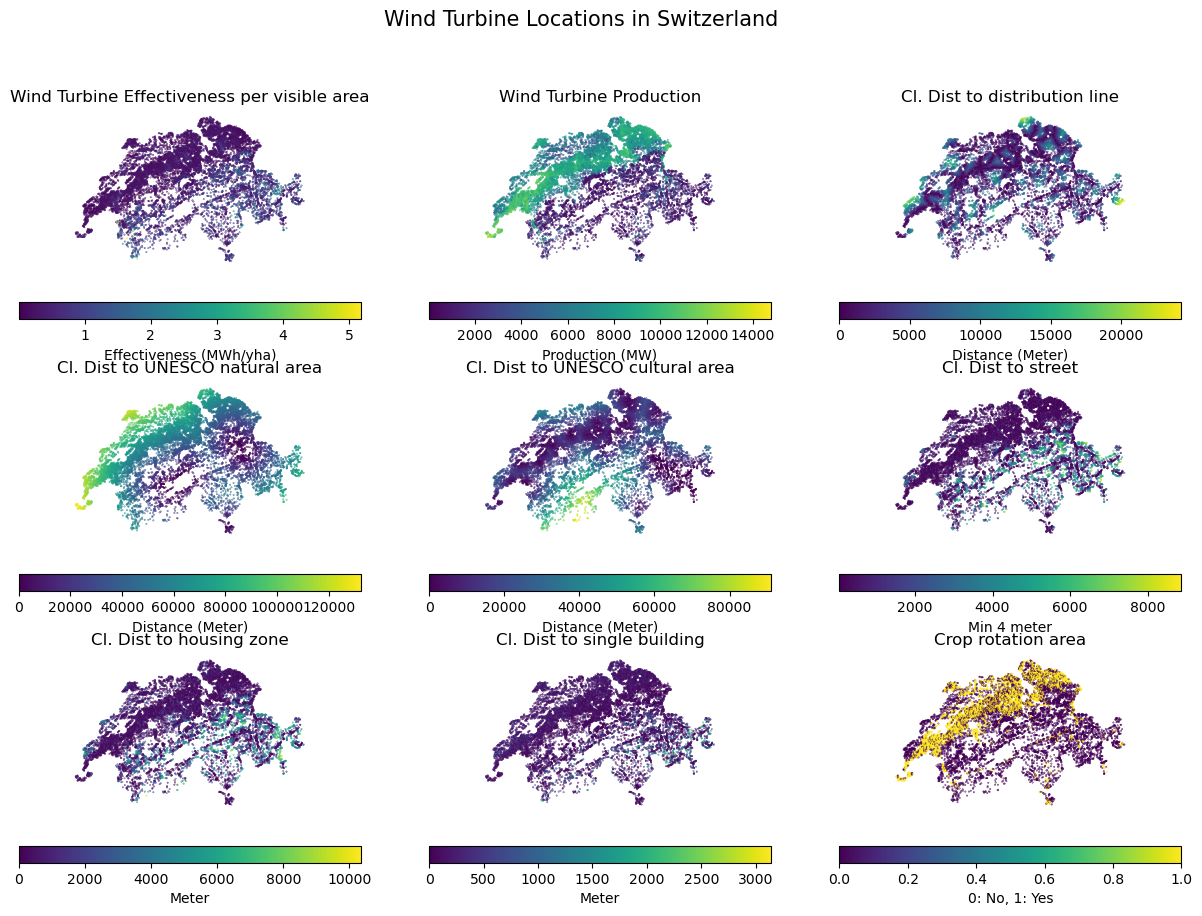

In [615]:

def create_subplot(gdf, columns, labels, titles, main_title, markersize=0.1, cmap='viridis', figsize=(15, 10)):
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    axes = axes.flatten()  # flatten the 2D array to 1D for easier looping

    for i in range(len(columns)):
        gdf.plot(column=columns[i], ax=axes[i], markersize=markersize, cmap=cmap, legend=True, legend_kwds={
            'label': labels[i], 'orientation': "horizontal"})
        axes[i].set_title(titles[i])
        axes[i].set_axis_off()


    if main_title:  # add a main title to the figure if provided
        fig.suptitle(main_title, size=15)


# Calling function to create a subplot
columns = ['ENER_DENS', 'prod_MW', 'DIST_PL', 'DIST_UNE_N', 'DIST_UNE_K',
           'DIST_STRE', 'DIST_HZ', 'DIST_BUILD', 'FFF']
labels = ["Effectiveness (MWh/yha)", "Production (MW)", "Distance (Meter)", "Distance (Meter)", "Distance (Meter)", "Min 4 meter",
          "Meter", "Meter", "0: No, 1: Yes"]
titles = ["Wind Turbine Effectiveness per visible area", "Wind Turbine Production", "Cl. Dist to distribution line",
          "Cl. Dist to UNESCO natural area", "Cl. Dist to UNESCO cultural area",
          "Cl. Dist to street", "Cl. Dist to housing zone", "Cl. Dist to single building", "Crop rotation area"]

create_subplot(gdf, columns, labels, titles,
               main_title="Wind Turbine Locations in Switzerland")


Plotting a correlation matrix between the different parameters

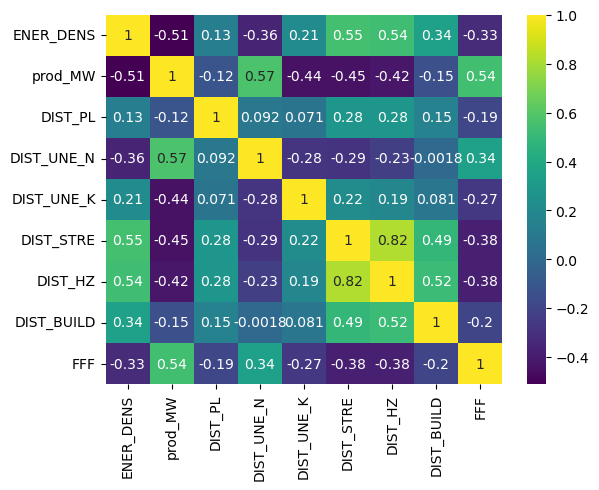

In [546]:

corr = gdf[columns].corr()

sns.heatmap(corr, annot=True, cmap='viridis')
plt.show()


## 3 Optimization

### 3.1 Minimizing the number of wind turbines while reaching 1.2TWh per year in total production

#### General motivation for minimizing the number of wind turbines

In the process of transitioning to more sustainable and renewable energy sources, the placement and number of wind turbines is a critical decision with both economic and environmental implications. Our primary goal is to meet the projected energy demand in 2035, which is estimated to be 1.2 TWh per year. However, in addressing this objective, we have to consider other important factors.

Firstly, it's important to minimize the number of wind turbines because each turbine represents not only a significant financial investment but also a physical intrusion into the landscape. Turbines can have visual and auditory impacts on the surrounding communities, and they can affect local wildlife, particularly bird and bat populations. By minimizing the number of turbines, we aim to reduce these potential negative impacts.

Secondly, the infrastructure required for wind turbines is considerable. Each turbine needs to be connected to the power grid, which may require building new transmission lines. Additionally, roads may need to be constructed or upgraded to allow for the transportation of turbine components and ongoing maintenance. By minimizing the number of turbines, we can reduce the extent of this necessary infrastructure and potentially lessen environmental disruption and costs.

Finally, the fewer turbines we use to meet the energy demand, the more efficient our solution. If we can meet our energy targets with fewer turbines, it means that we're making the most of the wind resources available, and our solution is economically and environmentally efficient.

Hence, the optimization problem that we are solving is not merely an academic exercise but a real-world problem with tangible implications for the economy, the environment, and society. It involves balancing the need for renewable energy with the desire to minimize the impact on the environment and communities. By formulating this as a binary integer programming problem, we can use powerful computational tools to find the optimal solution, aiding decision-makers in their task.



#### Problem Formulation 

This document provides a mathematical formulation for a specific optimization problem. The problem aims to minimize the number of wind turbines while ensuring a total power production of at least 1.2 TWh/yha.

#### Decision Variables 

Let's denote the binary decision variables with the letter $x$. Each $x_{i}$ represents whether a wind turbine is placed at location $i$ or not. If a wind turbine is placed at location $i$, $x_{i}$ will be 1, otherwise, it will be 0.

$x_{i} \in \{0, 1\}$ for each $i \in I$, where $I$ is the set of all locations.

#### Constraints 

The problem has a constraint on the total power production. The sum of the power production from all locations where wind turbines are placed should be at least 1.2 TWh/yha. 

Let $p_{i}$ represent the power production in MW from location $i$.

This can be mathematically represented as:

$\sum_{i \in I} x_{i} * p_{i} \geq 1200000$

#### Objective Function 

The objective is to minimize the total number of wind turbines, which is equivalent to the sum of the decision variables $x_{i}$.

This can be mathematically represented as:

$Minimize: \sum_{i \in I} x_{i}$

#### Solution 

The solution is a vector $x$ that satisfies the constraint and minimizes the objective function. If there is no such vector, the problem does not have an optimal solution.

In [547]:
def create_solver_for_wind_turbine_optimization(gdf, min_total_prod):
    # 1. Set up the solver
    solver = pywraplp.Solver.CreateSolver('SCIP')

    # 2. Define decision variables
    x = {}
    for i in range(len(gdf)):
        x[i] = solver.IntVar(0, 1, '')

    # 3. Define the constraint: total production should be min_total_prod or more
    solver.Add(sum(x[i] * gdf.prod_MW[i] for i in range(len(gdf))) >= min_total_prod)

    # 4. Define the objective function. 
    # Objective function: Minimize the number of wind turbines
    solver.Minimize(solver.Sum(x[i] for i in range(len(gdf))))

    return solver, x

def get_solutions_for_wind_turbine_optimization(solver, gdf, x):
    status = solver.Solve()

    # 6. Print the solution
    if status == pywraplp.Solver.OPTIMAL:
        selected_locations = []
        total_output = 0
        for i in range(len(gdf)):
            if x[i].solution_value() > 0:
                selected_locations.append(gdf.iloc[i]['geometry'])
                total_output = total_output + gdf.iloc[i]['prod_MW']
        print(f'Number of wind turbines needed: {len(selected_locations)}')
        print(f'Total power output: {total_output} MWh/y')
        print(f'Average power output: {total_output/len(selected_locations)} MWh/y')
        solver.Clear()
        return selected_locations
    else:
        print('The problem does not have an optimal solution.')
        solver.Clear()
        return None

solver, x = create_solver_for_wind_turbine_optimization(gdf, 1200000)
minimum_wind_turbine_locations = get_solutions_for_wind_turbine_optimization(solver, gdf, x)


Number of wind turbines needed: 101
Total power output: 1209160.3346111062 MWh/y
Average power output: 11971.884501100061 MWh/y


Now, we can use the same function and exclude all the areas where theres currently crop rotation

In [548]:
solver_no_crop, x = create_solver_for_wind_turbine_optimization(gdf, 1200000)

# Adding constraint so that every crop rotation location is set to zero
for i in range(len(gdf)):
    if gdf.FFF[i] == 1:
        solver_no_crop.Add(x[i] == 0)
        
minimum_wind_turbine_locations_no_crop = get_solutions_for_wind_turbine_optimization(solver_no_crop, gdf, x)


Number of wind turbines needed: 108
Total power output: 1203876.3280057383 MWh/y
Average power output: 11147.00303709017 MWh/y


Text(0.5, 1.0, 'Minimum number Wind Turbine and their locations in Switzerland')

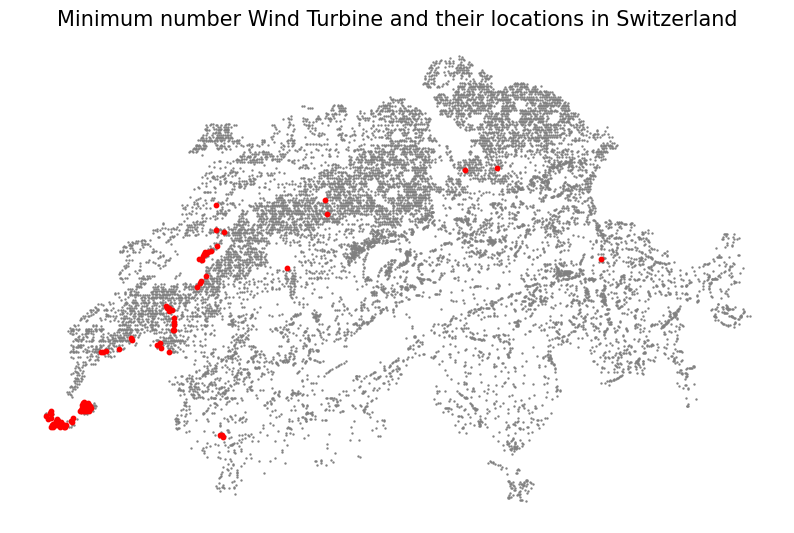

In [549]:
# Creating a new GeoDataFrame from selected locations
selected_gdf = gpd.GeoDataFrame(geometry=minimum_wind_turbine_locations)

# Ploting the selected locations on the map
ax = gdf.plot(color='grey', markersize=0.5, figsize=(10,10))
selected_gdf.plot(ax=ax, marker='o', color='red', markersize=10)

# Removing axis labels
ax.set_axis_off()

# Setting title
ax.set_title('Minimum number Wind Turbine and their locations in Switzerland', size=15)

Text(0.5, 1.0, 'Minimum number Wind Turbine and their locations (excluding crop area) in Switzerland')

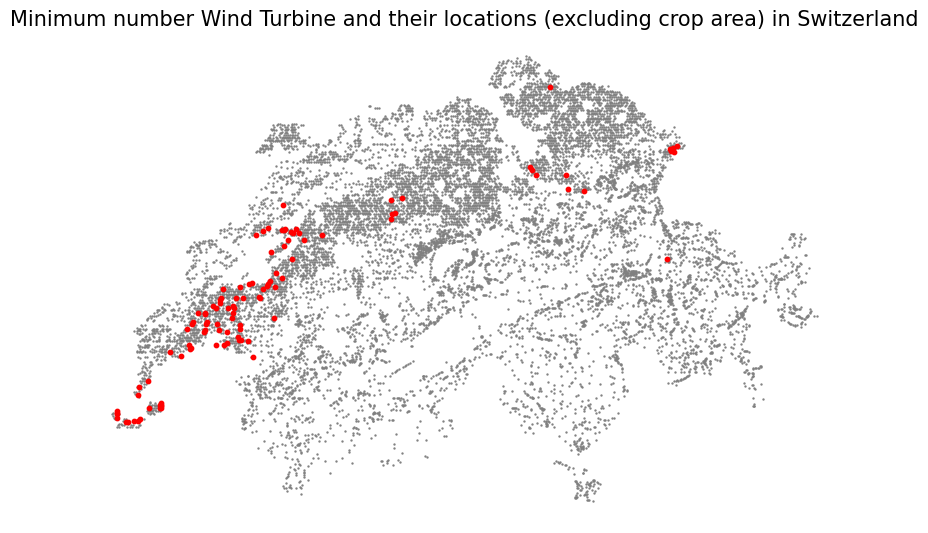

In [550]:
# Creating a new GeoDataFrame from selected locations
selected_gdf = gpd.GeoDataFrame(geometry=minimum_wind_turbine_locations_no_crop)

# Ploting the selected locations on the map
ax = gdf.plot(color='grey', markersize=0.5, figsize=(10,10))
selected_gdf.plot(ax=ax, marker='o', color='red', markersize=10)

# Removing axis labels
ax.set_axis_off()

# Setting title
ax.set_title('Minimum number Wind Turbine and their locations (excluding crop area) in Switzerland', size=15)

### 3.2. Additional constraints

Now, we can play with different constraints to see how the map changes.

#### Decision Variables 

Let's denote the binary decision variables with the letter $x$. Each $x_{i}$ represents whether a wind turbine is placed at location $i$ or not. If a wind turbine is placed at location $i$, $x_{i}$ will be 1, otherwise, it will be 0.

$x_{i} \in \{0, 1\}$ for each $i \in I$, where $I$ is the set of all locations.

#### Constraints 

The problem has several constraints:

**All choices should meet the energy demand of 1.2 TWh/year or more**

This constraint ensures that the total power produced by all selected wind turbines is at least 1.2 TWh per year. Let $p_{i}$ represent the power production in MW from location $i$. This can be mathematically represented as:

   $\sum_{i \in I} x_{i} * p_{i} \geq 1.2 * 10^6$

The other additional constraints that can be interactively changed are:


1. **Distance to Regional and National natural park should be more or equal to 2000m (2km)**

   If $d_{NAT,i} < 2000$, then $x_{i} = 0$

2. **Distance to Unesco heritage area should be more or equal to 2000m (2km)**

   This constraint ensures that no wind turbines are selected that are within 2km of a Unesco heritage area. Let $d_{UNE,i}$ represent the distance to the nearest Unesco heritage area from location $i$. This can be mathematically represented as:

   If $d_{UNE,i} < 2000$, then $x_{i} = 0$

3. **Distance to housing zone area should be more or equal to 1000m (1km)**

   This constraint ensures that no wind turbines are selected that are within 1km of a housing zone area. Let $d_{HZ,i}$ represent the distance to the nearest housing zone from location $i$. This can be mathematically represented as:

   If $d_{HZ,i} < 1000$, then $x_{i} = 0$

4. **Distance to transmission should be less or equal to 1500m (1,5km)**

   This constraint ensures that no wind turbines are selected that are more than 1,5km from a transmission line. Let $d_{PL,i}$ represent the distance to the nearest transmission line from location $i$. This can be mathematically represented as:

   If $d_{PL,i} > 1500$, then $x_{i} = 0$

5. **Avoid crop rotation area**

   This constraint ensures that no wind turbines are selected that are located in a crop rotation area. Let $f_{i}$ represent whether location $i$ is a crop rotation area or not. This can be mathematically represented as:

   If $f_{i} = 1$, then $x_{i} = 0$

#### Objective Function 

The objective is the same as before, but the difference is that we have included more constraints.

$Minimize: \sum_{i \in I} x_{i}$

#### Solution 

The solution is a vector $x$ that satisfies the constraints and maximizes the objective function. If there is no such vector, the problem does not have an optimal solution.

Dropdown(description='Constraint:', index=1, options=(('No Constraint', '0'), ('Distance to Unesco heritage ar…

Button(button_style='info', description='Optimize', style=ButtonStyle(), tooltip='Click to optimize wind turbi…

Constraint choice: 6


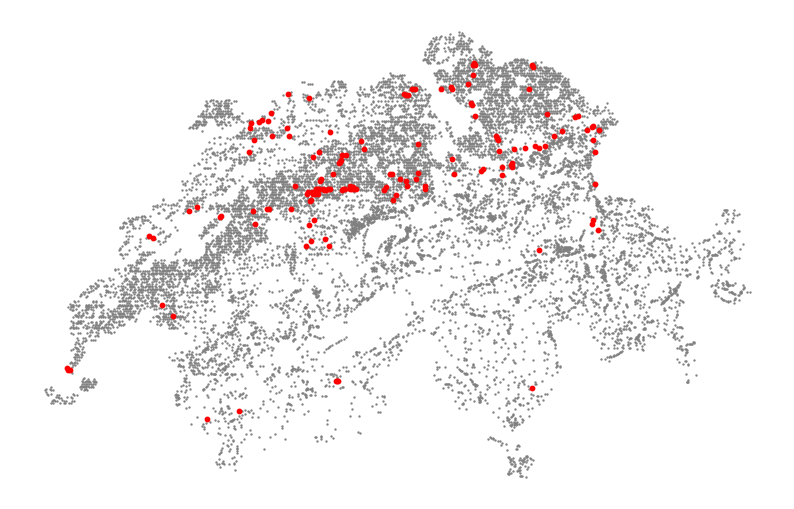

Number of wind turbines needed: 150
Power output: 1203496.6301682817 MWh/year
Avg. power output: 8023.310867788545 MWh/year per wind turbine
Unique Cantons: {'GraubÃ¼nden', 'Zug', 'St. Gallen', 'GenÃ¨ve', 'Bern', 'Schwyz', 'Solothurn', 'Luzern', 'Basel-Landschaft', 'Aargau', 'Valais', 'Jura', 'Thurgau', 'Appenzell Ausserrhoden', 'ZÃ¼rich', 'NeuchÃ¢tel', 'Ticino', 'Vaud'}


In [559]:
# Import widgets
from ipywidgets import interact, interactive, fixed, interact_manual, widgets


def apply_constraints_switzerland(solver, constraint_choice, gdf, x, reg_nat_park, unesco_threshold, housing_threshold, transmission_threshold):
    """Applies constraints to the solver based on user's choice."""

    print(f'Constraint choice: {constraint_choice}')

    # Total production should be 1.2 TWh/yha or more for all constraints
    solver.Add(sum(x[i] * gdf.prod_MW[i] for i in range(len(gdf))) >= 1200000)

    if constraint_choice == '1':
        # Distance to Unesco heritage area and regional natural park
        for i in range(len(gdf)):
            if gdf.DIST_REG_N[i] < reg_nat_park or gdf.DIST_NATPA[i] < reg_nat_park:
                solver.Add(x[i] == 0)
    
    if constraint_choice == '2':
        # Distance to Unesco heritage area and regional natural park
        for i in range(len(gdf)):
            if gdf.DIST_UNE_N[i] < unesco_threshold or gdf.DIST_UNE_K[i] < unesco_threshold:
                solver.Add(x[i] == 0)

    elif constraint_choice == '3':
        # Distance to housing zone area
        for i in range(len(gdf)):
            if gdf.DIST_HZ[i] < housing_threshold:
                solver.Add(x[i] == 0)

    elif constraint_choice == '4':
        # Distance to transmission lines
        for i in range(len(gdf)):
            if gdf.DIST_PL[i] > transmission_threshold:
                solver.Add(x[i] == 0)

    elif constraint_choice == '5':
        # Avoid crop rotation area
        for i in range(len(gdf)):
            if gdf.FFF[i] == 1:
                solver.Add(x[i] == 0)

    elif constraint_choice == '6':
        # Include all constraints
        for i in range(len(gdf)):
            if gdf.DIST_UNE_N[i] < unesco_threshold or gdf.DIST_UNE_K[i] < unesco_threshold:
                solver.Add(x[i] == 0)
            if gdf.DIST_REG_N[i] < reg_nat_park or gdf.DIST_NATPA[i] < reg_nat_park:
                solver.Add(x[i] == 0)
            if gdf.DIST_HZ[i] < housing_threshold:
                solver.Add(x[i] == 0)
            if gdf.DIST_PL[i] > transmission_threshold:
                solver.Add(x[i] == 0)
            if gdf.FFF[i] == 1:
                solver.Add(x[i] == 0)


def optimize_wind_turbine_placement_switzerland(b, reg_nat_park, unesco_threshold, housing_threshold, transmission_threshold):
    """Optimizes wind turbine placement based on constraints."""

    # Set up the solver
    solver = pywraplp.Solver.CreateSolver('SCIP')

    # Define decision variables
    x = {i: solver.IntVar(0, 1, '') for i in range(len(gdf))}

    # Define the constraints based on user's choice
    constraint_choice = dropdown.value
    apply_constraints_switzerland(solver, constraint_choice, gdf, x,
                      reg_nat_park, unesco_threshold, housing_threshold, transmission_threshold)

    # Define the objective function: Minimize the number of wind turbines
    solver.Minimize(solver.Sum(x[i] for i in range(len(gdf))))

    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        selected_locations = [gdf.iloc[i]['geometry']
                              for i in range(len(gdf)) if x[i].solution_value() > 0]

        # create a new GeoDataFrame from selected locations
        selected_gdf = gpd.GeoDataFrame(geometry=selected_locations)

        # plot the selected locations on the map
        ax = gdf.plot(color='grey', markersize=0.5, figsize=(10, 10))
        selected_gdf.plot(ax=ax, marker='o', color='red', markersize=10)

        # removing axis on the plot
        ax.axis('off')
        plt.show()

        num_turbines = len(selected_locations)
        total_output = sum(gdf.iloc[i]['prod_MW'] for i in range(
            len(gdf)) if x[i].solution_value() > 0)
        print(f'Number of wind turbines needed: {num_turbines}')
        print(f'Power output: {total_output} MWh/year')
        print(
            f'Avg. power output: {total_output/num_turbines} MWh/year per wind turbine')

        # Printing the unique Cantons where the wind turbines are placed
        cantons = []
        for i in range(len(gdf)):
            if x[i].solution_value() > 0:
                cantons.append(gdf.iloc[i]['CANT_NAME'])
        print(f'Unique Cantons: {set(cantons)}')
    else:
        print('The problem does not have an optimal solution.')


reg_nat_park = 2000
unesco_threshold = 2000
housing_threshold = 1000
transmission_threshold = 1500

# Create dropdown menu
dropdown = widgets.Dropdown(options=[
    (f'No Constraint', '0'),
    (f'Distance to Unesco heritage area should be more or equal to {unesco_threshold}m', '1'),
    (f'Distance to regional and natural park should be more or equal to {reg_nat_park}m', '2'),
    (f'Distance to housing zone area should be more or equal to {housing_threshold}m ', '3'),
    (f'Distance to transmission should be less or equal to {transmission_threshold}', '4'),
    ('Avoid crop rotation area', '5'),
    ('All constraints above', '6'),
],
    value='1',
    description='Constraint:',
)

button = widgets.Button(
    description='Optimize',
    button_style='info',   # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to optimize wind turbine placement',
)


def on_button_clicked(b):
    optimize_wind_turbine_placement_switzerland(
        dropdown.value, reg_nat_park, unesco_threshold, housing_threshold, transmission_threshold)


button.on_click(on_button_clicked)
display(dropdown, button)


We can visualize the findings using a interactive map

### 3.3 Clustering wind turbines

In [511]:
from sklearn.cluster import DBSCAN
import utm

gdf_clustered = gdf.to_crs(epsg=4326)  # ensure data is in lon/lat
geometry = gdf_clustered.geometry

# Extract latitude and longitude
coords = [(geom.y, geom.x) for geom in geometry]

# Convert lat/lon to UTM so that we can use Euclidean distance
utm_coords = [utm.from_latlon(coord[0], coord[1])[:2] for coord in coords]

# Run DBSCAN on UTM coordinate
# eps is the maximum distance between two points
db = DBSCAN(eps=750, min_samples=5)
clusters = db.fit_predict(utm_coords)

# Add cluster labels back to GeoDataFrame
gdf_clustered['cluster'] = clusters

# Getting the area and number of turbines in the clusters
cluster_areas = {}
cluster_number_of_turbines = {}

# Calculating the output (MWh/year) of the turbines in the clusters
cluster_output = {}
for cluster in np.unique(clusters):
    # Getting the number of turbines in the clusters

    if cluster == -1:
        cluster_number_of_turbines[cluster] = 0

    else:
        cluster_number_of_turbines[cluster] = len(
            gdf_clustered.geometry[clusters == cluster])  # Number of turbines in the cluster
        # (MWh/year) of the turbines in the clusters
        cluster_output[cluster] = sum(gdf_clustered.prod_MW[clusters == cluster])

    # Getting the area of the clusters
    cluster_areas[cluster] = gdf_clustered.geometry[clusters ==
                                          cluster].unary_union.convex_hull.area

# Map the dictionaries back to the DataFrame to create new columns
gdf_clustered['cluster_area'] = gdf_clustered['cluster'].map(cluster_areas)
gdf_clustered['cluster_number_of_turbines'] = gdf_clustered['cluster'].map(
    cluster_number_of_turbines)
gdf_clustered['cluster_output'] = gdf_clustered['cluster'].map(cluster_output)



In [512]:
display(len(gdf_clustered['cluster_number_of_turbines'].unique()))
display(gdf_clustered['cluster_number_of_turbines'].unique())
display(len(gdf_clustered['cluster_area'].unique()))

14

array([ 0,  8,  7,  6,  5,  4, 16, 21, 12, 11, 13,  9, 25, 10])

73

In [618]:
# Create a plotly map over the created clusters
import plotly.express as px

gdf_only_clusters = gdf_clustered[gdf_clustered['cluster'] != -1]

# Setting the color of the map to gray
fig = px.scatter_mapbox(gdf_only_clusters, size='prod_MW', lat=gdf_only_clusters.geometry.y,
                        lon=gdf_only_clusters.geometry.x, color='cluster_number_of_turbines', zoom=5, height=600, width=1000)

# Adding title to plot and centering it
fig.update_layout(title='Clusters of wind turbines',
                  title_x=0.5)

# Renaming the color bar
fig.update_layout(coloraxis_colorbar=dict(title='Number of turbines in cluster'))

# Setting the mapbox style to open street map and color gray
fig.update_layout(mapbox_style='open-street-map')
fig.show()


## 4 Case Study: Optimizing the placement of wind turbines in Vaud

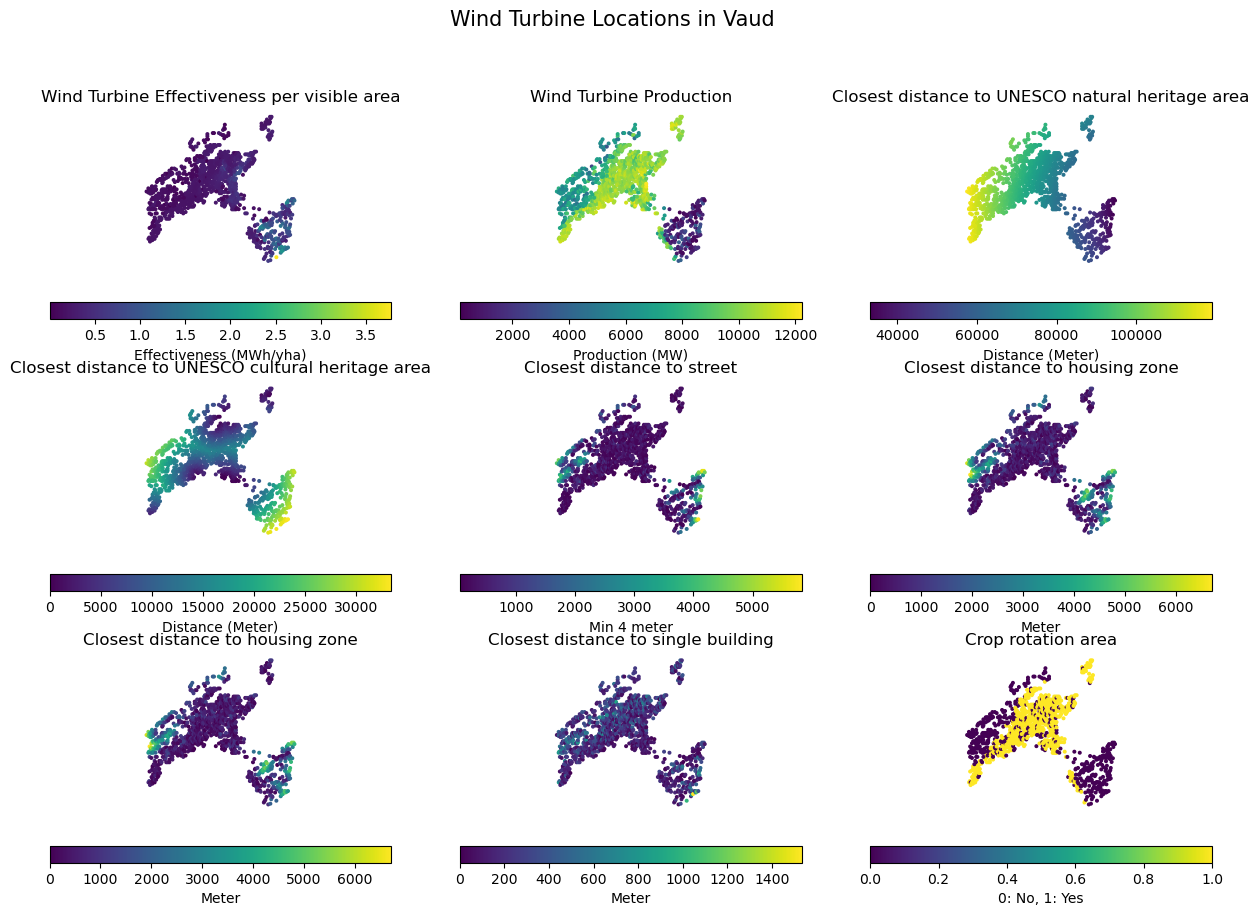

In [514]:
# Creating a figure with six subplots

gdf_vaud = gdf[gdf['CANT_NAME'] == 'Vaud'].copy()

# Calling function to create a subplot
columns = ['ENER_DENS', 'prod_MW', 'DIST_UNE_N', 'DIST_UNE_K',
           'DIST_STRE', 'DIST_HZ', 'DIST_HZ', 'DIST_BUILD', 'FFF']
labels = ["Effectiveness (MWh/yha)", "Production (MW)", "Distance (Meter)", "Distance (Meter)", "Min 4 meter",
          "Meter", "Meter", "Meter", "0: No, 1: Yes"]
titles = ["Wind Turbine Effectiveness per visible area", "Wind Turbine Production",
          "Closest distance to UNESCO natural heritage area", "Closest distance to UNESCO cultural heritage area",
          "Closest distance to street", "Closest distance to housing zone",
          "Closest distance to housing zone", "Closest distance to single building", "Crop rotation area"]

create_subplot(gdf_vaud, columns, labels, titles,
               main_title="Wind Turbine Locations in Canton de Vaud", markersize=3.5)


Constraint choice: 1


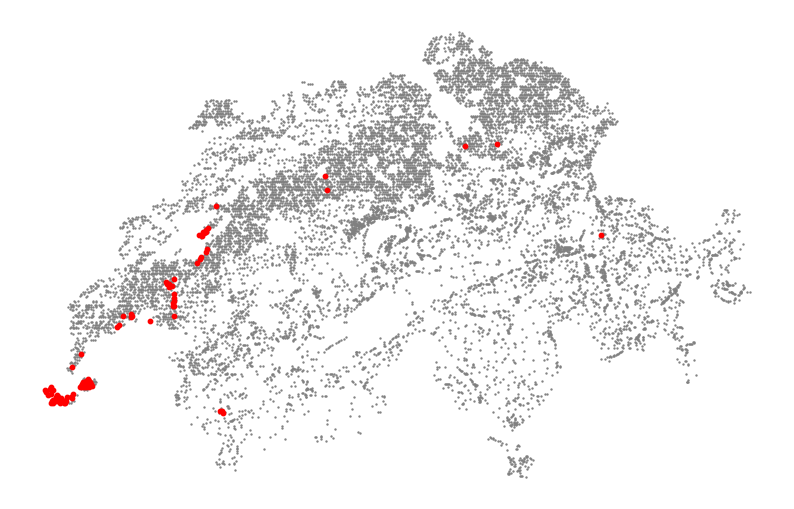

Number of wind turbines needed: 101
Power output: 1204137.6012866218 MWh/year
Avg. power output: 11922.154468184373 MWh/year per wind turbine
Unique Cantons: {'GraubÃ¼nden', 'GenÃ¨ve', 'ZÃ¼rich', 'Bern', 'Valais', 'Fribourg', 'Vaud'}


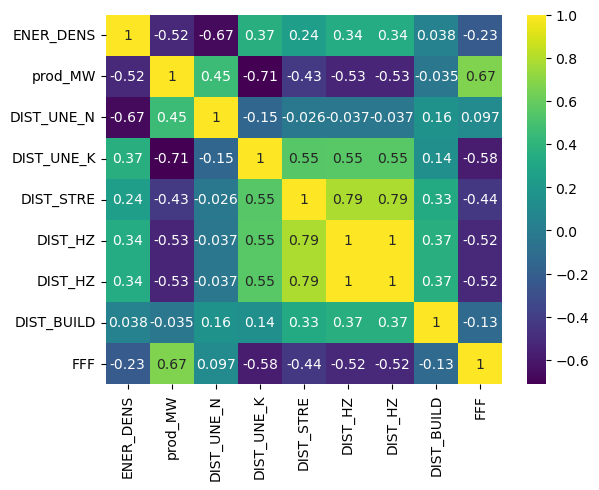

In [515]:
# Plotting the correlation matrix of the data

corr_vaud = gdf_vaud[columns].corr()

sns.heatmap(corr_vaud, annot=True, cmap='viridis')
plt.show()


For the Canon de Vaud, the energy target has to be smaller. Lets scalled down by the relative number of population.
- Vaud population: Le canton compte 831’327 personnes à fin 2022 (https://www.vd.ch/themes/etat-droit-finances/statistique/statistiques-par-domaine/01-population/etat-et-structure-de-la-population)
- Swiss population: Au 31 décembre 2022, la population résidente permanente en Suisse comptait 8'812'700 personnes (https://www.24heures.ch/il-manque-190000-personnes-pour-passer-le-cap-des-9-millions-441499480026#)

In [516]:
# Ratio of the Vaud Canton population vs Switzerland
ratio_pop = 831327/8812700
ratio_pop

0.09433283783630443

Let's try to scalled it down by the Canton de Vaud GDP:

- Vaud GDD: Selon les dernières estimations d'avril 2023, le PIB vaudois s’est élevé à 62,3 milliards de francs en 2022 et représentait alors 8% du PIB national. https://www.vd.ch/themes/etat-droit-finances/statistique/statistiques-par-domaine/04-economie-nationale-pib-vaudois/pib-vaudois#:~:text=Selon%20les%20dernières%20estimations%20d,alors%208%25%20du%20PIB%20national.



Rational: Tounjours vu une strong correlation entre le GDP et energy output (put source of Janco). So makes more sense to do its that way

In [517]:
ratio_gdp = 0.08

In [518]:
gdf_vaud.prod_MW

35       10664.948813
39       10758.880055
43       11388.028438
44       10975.196267
46       11250.204831
             ...     
11330     9394.227855
11331     9179.784796
11373     5778.522468
11379     6747.197416
11409     1021.885733
Name: prod_MW, Length: 1225, dtype: float64

In [519]:
gdf_vaud = gdf_vaud.reset_index(drop=True)

In [520]:
1200000 *ratio_gdp

96000.0

Dropdown(description='Constraint:', options=(('No Constraint', '0'), ('Distance to regional and national parks…

Button(button_style='info', description='Optimize', style=ButtonStyle(), tooltip='Click to optimize wind turbi…

Optimization results
------------------------------------------
Number of wind turbines needed: 9
Energy output: 0.0982 TWh/y


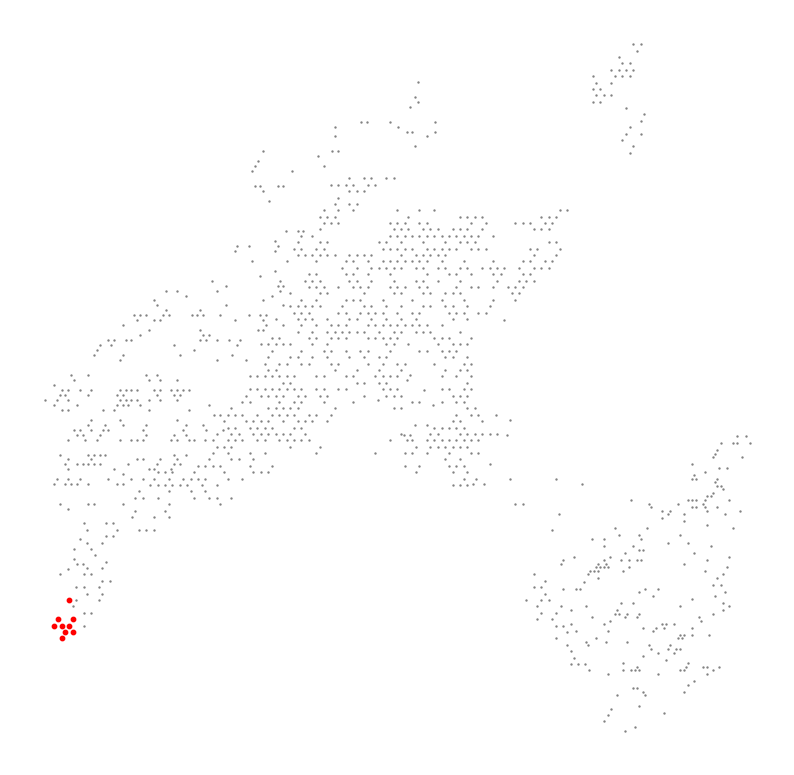

In [521]:
# Import widgets
from ipywidgets import interact, interactive, fixed, interact_manual, widgets


def apply_constraints(solver, constraint_choice, gdf, x, reg_nat_threshold, unesco_threshold, housing_threshold, transmission_threshold):
    """Applies constraints to the solver based on user's choice."""

    # Total production should be 1.2 TWh/yha or more for all constraints
    solver.Add(sum(x[i] * gdf.prod_MW[i] for i in range(len(gdf))) >= 1200000*ratio_gdp)

    if constraint_choice == '1':
        # Distance to Unesco heritage area
        for i in range(len(gdf)):
            if gdf.DIST_UNE_N[i] < unesco_threshold or gdf.DIST_UNE_K[i] < unesco_threshold:
                solver.Add(x[i] == 0)

    if constraint_choice == '2':
        # Distance to regional and national natural park
        for i in range(len(gdf)):
            if gdf.DIST_REG_N[i] < reg_nat_threshold or gdf.DIST_NATPA[i] < reg_nat_threshold:
                solver.Add(x[i] == 0)

    elif constraint_choice == '3':
        # Distance to housing zone area should be more or equal to 1000m (1km)
        for i in range(len(gdf)):
            if gdf.DIST_HZ[i] < housing_threshold:
                solver.Add(x[i] == 0)

    elif constraint_choice == '4':
        # Distance to transmission should be less or equal to 1500m (1.5km)
        for i in range(len(gdf)):
            if gdf.DIST_PL[i] > transmission_threshold:
                solver.Add(x[i] == 0)

    elif constraint_choice == '5':
        # Avoid crop rotation area
        for i in range(len(gdf)):
            if gdf.FFF[i] == 1:
                solver.Add(x[i] == 0)

    elif constraint_choice == '6':
        # Include all constraints
        for i in range(len(gdf)):
            if gdf.DIST_UNE_N[i] < unesco_threshold or gdf.DIST_UNE_K[i] < unesco_threshold:
                solver.Add(x[i] == 0)
            if gdf.DIST_REG_N[i] < reg_nat_threshold or gdf.DIST_NATPA[i] < reg_nat_threshold:
                solver.Add(x[i] == 0)
            if gdf.DIST_HZ[i] < housing_threshold:
                solver.Add(x[i] == 0)
            if gdf.DIST_PL[i] > transmission_threshold:
                solver.Add(x[i] == 0)
            if gdf.FFF[i] == 1:
                solver.Add(x[i] == 0)


def optimize_wind_turbine_placement(b, reg_nat_threshold, unesco_threshold, housing_threshold, transmission_threshold):
    """Optimizes wind turbine placement based on constraints."""
    gdf = gdf_vaud.copy()

    # Set up the solver
    solver = pywraplp.Solver.CreateSolver('SCIP')

    # Define decision variables
    x = {i: solver.IntVar(0, 1, '') for i in range(len(gdf))}

    # Define the constraints based on user's choice
    constraint_choice = dropdown.value
    apply_constraints(solver, constraint_choice, gdf_vaud, x, reg_nat_threshold,
                      unesco_threshold, housing_threshold, transmission_threshold)
    

    # Define the objective function: Minimize the number of wind turbines
    solver.Minimize(solver.Sum(x[i] for i in range(len(gdf))))

    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        selected_locations = [gdf.iloc[i]['geometry']
                              for i in range(len(gdf)) if x[i].solution_value() > 0]

        # create a new GeoDataFrame from selected locations
        selected_gdf = gpd.GeoDataFrame(geometry=selected_locations)

        num_turbines = len(selected_locations)
        total_output = sum(gdf.iloc[i]['prod_MW'] for i in range(
            len(gdf)) if x[i].solution_value() > 0)
        print('Optimization results')
        print('------------------------------------------')
        print(f'Number of wind turbines needed: {num_turbines}')
        print(f'Energy output: {np.round(total_output/1000000, 4)} TWh/y')
         # plot the selected locations on the map
        ax = gdf.plot(color='grey', markersize=0.5, figsize=(10, 10))
        selected_gdf.plot(ax=ax, marker='o', color='red', markersize=10)

        # removing axis on the plot
        ax.axis('off')
        plt.show()
    else:
        print('The problem does not have an optimal solution.')

reg_nat_threshold = 2000
unesco_threshold = 2000
housing_threshold = 650
transmission_threshold = 2000

#reg_nat_threshold = 500
#unesco_threshold = 500
#housing_threshold = 450
#transmission_threshold = 10000

# Create dropdown menu
dropdown = widgets.Dropdown(options=[
    (f'No Constraint', '0'),
    (f'Distance to regional and national parks should be more or equal to {reg_nat_threshold}m', '1'),
    (f'Distance to Unesco heritage area should be more or equal to {unesco_threshold}m', '2'),
    (f'Distance to housing zone area should be more or equal to {housing_threshold}m ', '3'),
    (f'Distance to transmission should be less or equal to {transmission_threshold}', '4'),
    ('Avoid crop rotation area', '5'),
    ('All constraints above', '6'),
],
    value='0',
    description='Constraint:',
)

button = widgets.Button(
    description='Optimize',
    button_style='info',   # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to optimize wind turbine placement',
)


def on_button_clicked(b):
    optimize_wind_turbine_placement(
        dropdown.value, reg_nat_threshold, unesco_threshold, housing_threshold, transmission_threshold)


button.on_click(on_button_clicked)
display(dropdown, button)

optimize_wind_turbine_placement(
        dropdown.value, reg_nat_threshold, unesco_threshold, housing_threshold, transmission_threshold)


## 5 Case Study: Optimizing clusters in Vaud

Creating cluster with the DBSCAN algorithm. DBSCAN works by identifying points that are in crowded regions of the feature space, where many data points are close together (dense regions in feature space). These regions are referred to as clusters. The DBSCAN algorithm requires two parameters: epsilon and minimum points. Epsilon specifies how close points should be to each other to be considered a part of a cluster. It is the radius of neighborhood around a point x. Minimum points specify the minimum number of points to form a dense region. For example, if minimum samples = 5, then it means that for a point to be considered a core point, it should have at least 5 points within its radius.

In [522]:
from sklearn.cluster import DBSCAN
import utm

gdf_vaud = gdf_vaud.to_crs(epsg=4326)  # ensure data is in lon/lat
geometry = gdf_vaud.geometry

# Extract latitude and longitude
coords = [(geom.y, geom.x) for geom in geometry]

# Convert lat/lon to UTM so that we can use Euclidean distance
utm_coords = [utm.from_latlon(coord[0], coord[1])[:2] for coord in coords]

# Run DBSCAN on UTM coordinate
# eps is the maximum distance between two points
db = DBSCAN(eps=800, min_samples=3)
clusters = db.fit_predict(utm_coords)

# Add cluster labels back to GeoDataFrame
gdf_vaud['cluster'] = clusters

cluster_number_of_turbines = {}

# Calculating the output (MWh/year) of the turbines in the clusters
cluster_output = {}
for cluster in np.unique(clusters):
    # Getting the number of turbines in the clusters

    if cluster == -1:
        cluster_number_of_turbines[cluster] = 0

    else:
        cluster_number_of_turbines[cluster] = len(
            gdf_vaud.geometry[clusters == cluster])  # Number of turbines in the cluster
        # (MWh/year) of the turbines in the clusters
        cluster_output[cluster] = sum(gdf_vaud.prod_MW[clusters == cluster])

# Calculate centroid of each cluster in UTM
cluster_centroids = {}
for cluster in np.unique(clusters):
    if cluster != -1:  # Ignore noise points
        members = [coord for idx, coord in enumerate(utm_coords) if clusters[idx] == cluster]
        centroid = np.mean(members, axis=0)
        cluster_centroids[cluster] = centroid

# Convert UTM centroids to lat/long and store in separate dictionaries
cluster_latitudes = {}
cluster_longitudes = {}
for cluster, centroid in cluster_centroids.items():
    lat, lon = utm.to_latlon(centroid[0], centroid[1], 32, 'U')  # Update UTM zone and hemisphere
    cluster_latitudes[cluster] = lat
    cluster_longitudes[cluster] = lon

# Add centroid latitude and longitude as new columns
gdf_vaud['cluster_latitude'] = gdf_vaud['cluster'].map(cluster_latitudes)
gdf_vaud['cluster_longitude'] = gdf_vaud['cluster'].map(cluster_longitudes)

gdf_vaud['cluster_number_of_turbines'] = gdf_vaud['cluster'].map(
    cluster_number_of_turbines)
gdf_vaud['cluster_output'] = gdf_vaud['cluster'].map(cluster_output)



In [523]:
# Printing the number of clusters
print(f'Number of clusters: {len(np.unique(clusters))}')

gdf_vaud

Number of clusters: 43


,PU_ID,LT,WT_ID,DIST_ISOS,DIST_UNE_N,DIST_UNE_K,DIST_BLN,DIST_VAEW,DIST_RAD,DIST_AIR,...,weigh_stre,prod_MW,KIBK,CANT_NAME,geometry,cluster,cluster_latitude,cluster_longitude,cluster_number_of_turbines,cluster_output
0,4581.0,1.0,145.0,4434.0,118209.0,5342.0,103.0,104465.0,11379.0,4026.0,...,320.999912,10664.948813,4.0,Vaud,POINT (6.13836 46.32764),-1,NaN,NaN,0,NaN
1,4723.0,1.0,157.0,4298.0,117667.0,5896.0,97.0,104089.0,10748.0,4419.0,...,375.999960,10758.880055,4.0,Vaud,POINT (6.14403 46.33472),-1,NaN,NaN,0,NaN
2,4864.0,1.0,165.0,3393.0,117526.0,3550.0,1827.0,103423.0,13117.0,2626.0,...,362.999912,11388.028438,4.0,Vaud,POINT (6.15038 46.31375),-1,NaN,NaN,0,NaN
3,4865.0,1.0,166.0,3575.0,117317.0,5012.0,874.0,103569.0,11627.0,3585.0,...,164.000053,10975.196267,3.0,Vaud,POINT (6.15004 46.32777),-1,NaN,NaN,0,NaN
4,5006.0,1.0,173.0,2951.0,116973.0,4136.0,1657.0,103054.0,12509.0,2751.0,...,661.999978,11250.204831,4.0,Vaud,POINT (6.15605 46.32083),-1,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,36562.0,3.0,89751.0,2745.0,61724.0,1331.0,3827.0,55420.0,50186.0,16704.0,...,497.000249,9394.227855,4.0,Vaud,POINT (6.85871 46.49414),-1,NaN,NaN,0,NaN
1221,36568.0,3.0,89752.0,2370.0,62483.0,7420.0,9610.0,59265.0,52647.0,15800.0,...,289.999778,9179.784796,5.0,Vaud,POINT (6.85801 46.55958),-1,NaN,NaN,0,NaN
1222,39482.0,3.0,89822.0,4388.0,56131.0,6212.0,6318.0,50583.0,44827.0,14135.0,...,1082.999794,5778.522468,5.0,Vaud,POINT (6.93166 46.49449),-1,NaN,NaN,0,NaN
1223,39661.0,3.0,89829.0,2453.0,55726.0,6901.0,3053.0,48170.0,43371.0,14340.0,...,877.999086,6747.197416,1.0,Vaud,POINT (6.93657 46.45633),-1,NaN,NaN,0,NaN


In [524]:
gdf_vaud_clusters = gdf_vaud[gdf_vaud['cluster'] != -1]
display(gdf_vaud_clusters.head(5))
gdf_vaud_clusters.isna().sum()

,PU_ID,LT,WT_ID,DIST_ISOS,DIST_UNE_N,DIST_UNE_K,DIST_BLN,DIST_VAEW,DIST_RAD,DIST_AIR,...,weigh_stre,prod_MW,KIBK,CANT_NAME,geometry,cluster,cluster_latitude,cluster_longitude,cluster_number_of_turbines,cluster_output
18,5863.0,1.0,235.0,3956.0,113487.0,11884.0,3027.0,101315.0,7880.0,2937.0,...,284.000064,11022.338391,1.0,Vaud,POINT (6.18950 46.39134),17,46.396077,6.177844,4,35765.458973
51,8569.0,1.0,417.0,3037.0,104723.0,15622.0,1899.0,95622.0,17124.0,7751.0,...,667.999920,8667.747747,4.0,Vaud,POINT (6.29844 46.49768),26,46.503412,6.295062,5,34832.140282
60,9137.0,1.0,443.0,2602.0,102924.0,13827.0,1558.0,93902.0,18752.0,8433.0,...,314.999924,8929.276390,4.0,Vaud,POINT (6.32189 46.49791),29,46.506914,6.325937,6,44618.401727
424,17944.0,1.0,1264.0,3928.0,75426.0,2971.0,3464.0,69763.0,46675.0,2476.0,...,215.000277,10089.732768,1.0,Vaud,POINT (6.68476 46.54298),0,46.540080,6.693800,5,46248.079962
449,18369.0,1.0,1316.0,3174.0,74000.0,1923.0,2531.0,68205.0,47784.0,3921.0,...,329.000000,11092.962956,5.0,Vaud,POINT (6.70246 46.53608),0,46.540080,6.693800,5,46248.079962


PU_ID                         0
LT                            0
WT_ID                         0
DIST_ISOS                     0
DIST_UNE_N                    0
DIST_UNE_K                    0
DIST_BLN                      0
DIST_VAEW                     0
DIST_RAD                      0
DIST_AIR                      0
DIST_MIL                      0
DIST_FLOOD                    0
DIST_MEAD                     0
DIST_JB                       0
DIST_BIOS                     0
DIST_STRE                     0
DIST_FOR                      0
DIST_HZ                       0
DIST_IZ                       0
DIST_PL                       0
DIST_BUILD                    0
ALTI                          0
NOISE                         0
FFF                           0
VIS_AREA                      0
VIS_IMPACT                    0
VIS_INFRA                     0
VIS_POP                       0
COHER_AREA                    0
VIS_ARE_ha                    0
ENER_DENS                     0
DIST_NAT

In [629]:
# Create a plotly map over the created clusters

import plotly.express as px

gdf_vaud_clusters = gdf_vaud[gdf_vaud['cluster'] != -1]

fig = px.scatter_mapbox(gdf_vaud_clusters, size='cluster_output', lat=gdf_vaud_clusters.geometry.y,
                        lon=gdf_vaud_clusters.geometry.x, color='cluster_number_of_turbines', zoom=8, height=600, width=1000)

# Adding title to plot and centering it
fig.update_layout(title='Clusters of wind turbines',
                  title_x=0.5)

# Change the name of the color bar
fig.update_layout(coloraxis_colorbar=dict(title='Number of turbines'))

# Setting the mapbox style to open street map and color gray
fig.update_layout(mapbox_style='open-street-map')
fig.show()


In [526]:
gdf_vaud_clusters.head()

,PU_ID,LT,WT_ID,DIST_ISOS,DIST_UNE_N,DIST_UNE_K,DIST_BLN,DIST_VAEW,DIST_RAD,DIST_AIR,...,weigh_stre,prod_MW,KIBK,CANT_NAME,geometry,cluster,cluster_latitude,cluster_longitude,cluster_number_of_turbines,cluster_output
18,5863.0,1.0,235.0,3956.0,113487.0,11884.0,3027.0,101315.0,7880.0,2937.0,...,284.000064,11022.338391,1.0,Vaud,POINT (6.18950 46.39134),17,46.396077,6.177844,4,35765.458973
51,8569.0,1.0,417.0,3037.0,104723.0,15622.0,1899.0,95622.0,17124.0,7751.0,...,667.999920,8667.747747,4.0,Vaud,POINT (6.29844 46.49768),26,46.503412,6.295062,5,34832.140282
60,9137.0,1.0,443.0,2602.0,102924.0,13827.0,1558.0,93902.0,18752.0,8433.0,...,314.999924,8929.276390,4.0,Vaud,POINT (6.32189 46.49791),29,46.506914,6.325937,6,44618.401727
424,17944.0,1.0,1264.0,3928.0,75426.0,2971.0,3464.0,69763.0,46675.0,2476.0,...,215.000277,10089.732768,1.0,Vaud,POINT (6.68476 46.54298),0,46.540080,6.693800,5,46248.079962
449,18369.0,1.0,1316.0,3174.0,74000.0,1923.0,2531.0,68205.0,47784.0,3921.0,...,329.000000,11092.962956,5.0,Vaud,POINT (6.70246 46.53608),0,46.540080,6.693800,5,46248.079962


Creating a df with the clusters grouped by the cluster number. So that each observation/row in the dataframe represents a collection of wind turbines that are close to each other.

In [527]:
gdf_vaud_clusters = gdf_vaud[gdf_vaud['cluster'] != -1]
grouped = gdf_vaud_clusters.groupby('cluster')

# Aggregate values
vaud_cluster_df = grouped.agg({
    'cluster_number_of_turbines': 'first',  
    'cluster_output': 'first',
    'geometry': lambda x: x.unary_union, # Combine all geometries into one MultiPolygon geometry
    'cluster_latitude': 'first',  
    'cluster_longitude': 'first',
    'ENER_DENS': 'mean',
    'DIST_UNE_N': 'mean',
    'DIST_UNE_K': 'mean',
    'DIST_REG_N': 'mean',
    'DIST_NATPA': 'mean',
    'DIST_HZ': 'mean',
    'DIST_PL': 'mean',
    'FFF': lambda x: (x.sum() / x.count() > 0.80).astype(int) # If more than X% of the values are 1, then the group is set to 1
})

# Reset index
vaud_cluster_df.reset_index(inplace=True)
vaud_cluster_df.head()
vaud_cluster_df.shape


(42, 14)

In [612]:
fig = px.scatter_mapbox(vaud_cluster_df, size='cluster_output', lat=vaud_cluster_df.cluster_latitude,
                        lon=vaud_cluster_df.cluster_longitude, color='cluster_number_of_turbines', zoom=8, height=600, width=1000)

# Adding title to plot and centering it
fig.update_layout(title='Clusters of wind turbines (Grouped)',
                  title_x=0.5)

# Change the name of the color bar
fig.update_layout(coloraxis_colorbar=dict(title='Number of turbines'))

# Setting the mapbox style to open street map and color gray
fig.update_layout(mapbox_style='open-street-map')
fig.show()

Based on the previous clusters we can try to optimize the locations of these clusters. We can do this by using the same optimization problem as in the previous section, but now we have to take into account the clusters. 

In [529]:
vaud_cluster_df.head()

,cluster,cluster_number_of_turbines,cluster_output,geometry,cluster_latitude,cluster_longitude,ENER_DENS,DIST_UNE_N,DIST_UNE_K,DIST_REG_N,DIST_NATPA,DIST_HZ,DIST_PL,FFF
0,0,5,46248.079962,"MULTIPOINT (6.68476 46.54298, 6.68934 46.54223...",46.540080,6.693800,0.166243,74704.600000,2471.200000,18853.510574,256455.183364,271.400000,352.400000,0
1,1,11,14549.219354,"MULTIPOINT (6.98334 46.39030, 6.98656 46.39421...",46.397807,7.000717,1.651729,51433.545455,14487.727273,999.601995,234276.417557,4188.818182,4427.181818,0
2,2,3,6544.052756,"MULTIPOINT (7.02593 46.34761, 7.02914 46.35152...",46.348921,7.029163,0.930645,50462.000000,19733.666667,3920.668994,232801.049969,476.000000,1197.666667,0
3,3,4,6227.404529,"MULTIPOINT (7.05235 46.28537, 7.05884 46.28539...",46.286371,7.059646,0.584785,50609.000000,26529.750000,9477.296501,231559.292744,413.500000,4638.250000,0
4,4,3,4831.722629,"MULTIPOINT (7.10070 46.33617, 7.10397 46.33229...",46.334883,7.103956,1.221902,45440.333333,25036.000000,4287.424246,227329.499547,2659.666667,4508.666667,0


Number of clusters needed: 1
Number of wind turbines needed: 15
Energy output: 0.1031 TWh/y


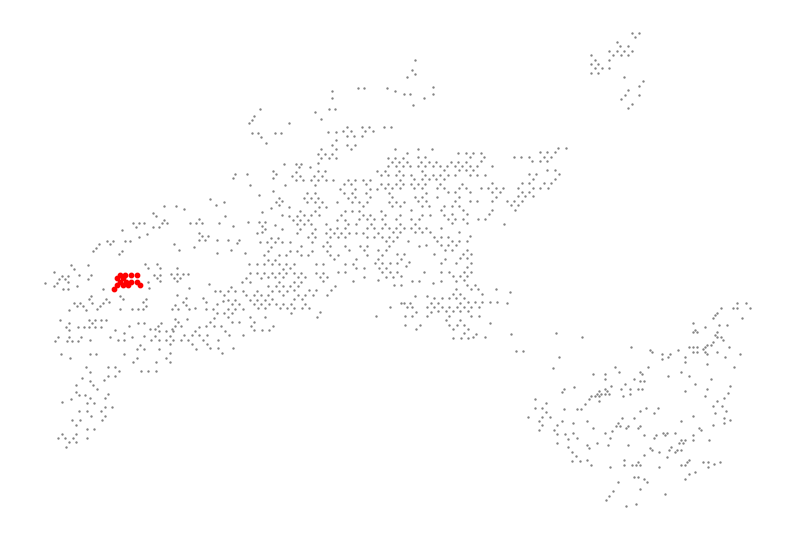

In [530]:

gdf = vaud_cluster_df

# Set up the solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# Define decision variables
x = {i: solver.IntVar(0, 1, '') for i in range(len(gdf))}

# Total production should be 1.2 TWh/yha or more for all constraints
solver.Add(sum(x[i] * gdf.cluster_output[i] for i in range(len(gdf))) >= 1200000*ratio_gdp)

# Define the objective function: Minimize the number of wind turbines
solver.Minimize(solver.Sum(x[i] for i in range(len(gdf))))

status = solver.Solve()
if status == pywraplp.Solver.OPTIMAL:

	selected_locations = [gdf.iloc[i]['geometry']
							for i in range(len(gdf)) if x[i].solution_value() > 0]
	
	number_of_turbines = [gdf.iloc[i]['cluster_number_of_turbines']
							for i in range(len(gdf)) if x[i].solution_value() > 0]
	

	# create a new GeoDataFrame from selected locations
	selected_gdf = gpd.GeoDataFrame(geometry=selected_locations)

	# plot the selected locations on the map
	ax = gdf_vaud.plot(color='grey', markersize=0.5, figsize=(10, 10))
	selected_gdf.plot(ax=ax, marker='o', color='red', markersize=10)

	# removing axis on the plot
	ax.axis('off')

	num_clusters = len(selected_locations)
	total_output = sum(gdf.iloc[i]['cluster_output'] for i in range(
		len(gdf)) if x[i].solution_value() > 0)

	
	print(f'Number of clusters needed: {num_clusters}')
	print(f'Number of wind turbines needed: {np.sum(number_of_turbines)}')
	print(f'Energy output: {np.round(total_output/1000000, 4)} TWh/y')
	plt.show()

else:
	print('The problem does not have an optimal solution.')




Optimization results
------------------------------------------
Number of wind turbines 17
Number of clusters needed: 2
Energy output: 0.1106 TWh/y


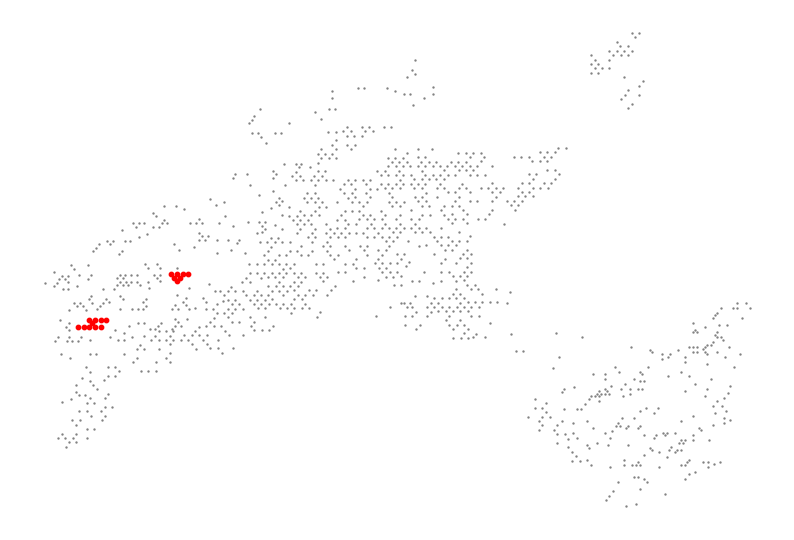

In [531]:
reg_nat_threshold = 0
unesco_threshold = 300
housing_threshold = 400
transmission_threshold = 10000

gdf = vaud_cluster_df

# Set up the solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# Define decision variables
x = {i: solver.IntVar(0, 1, '') for i in range(len(gdf))}

# Total production should be 1.2 TWh/yha or more for all constraints
solver.Add(sum(x[i] * gdf.cluster_output[i] for i in range(len(gdf))) >= 1200000*ratio_gdp)

for i in range(len(gdf)):
	if gdf.DIST_UNE_N[i] < unesco_threshold or gdf.DIST_UNE_K[i] < unesco_threshold:
		solver.Add(x[i] == 0)
	if gdf.DIST_REG_N[i] < reg_nat_threshold or gdf.DIST_NATPA[i] < reg_nat_threshold:
				solver.Add(x[i] == 0)
	if gdf.DIST_HZ[i] < housing_threshold:
				solver.Add(x[i] == 0)
	if gdf.DIST_PL[i] > transmission_threshold:
				solver.Add(x[i] == 0)
	if gdf.FFF[i] == 1:
				solver.Add(x[i] == 0)

# Define the objective function: Minimize the number of wind turbines
solver.Minimize(solver.Sum(x[i] for i in range(len(gdf))))

status = solver.Solve()
if status == pywraplp.Solver.OPTIMAL:

	selected_locations = [gdf.iloc[i]['geometry']
							for i in range(len(gdf)) if x[i].solution_value() > 0]
	
	number_of_turbines = [gdf.iloc[i]['cluster_number_of_turbines']
							for i in range(len(gdf)) if x[i].solution_value() > 0]
	

	# create a new GeoDataFrame from selected locations
	selected_gdf = gpd.GeoDataFrame(geometry=selected_locations)

	# plot the selected locations on the map
	ax = gdf_vaud.plot(color='grey', markersize=0.5, figsize=(10, 10))
	selected_gdf.plot(ax=ax, marker='o', color='red', markersize=10)

	# removing axis on the plot
	ax.axis('off')

	num_clusters = len(selected_locations)
	total_output = sum(gdf.iloc[i]['cluster_output'] for i in range(
		len(gdf)) if x[i].solution_value() > 0)
	print('Optimization results')
	print('------------------------------------------')
	print(f'Number of wind turbines {np.sum(number_of_turbines)}')
	print(f'Number of clusters needed: {num_clusters}')
	print(f'Energy output: {np.round(total_output/1000000,4)} TWh/y')
	plt.show()

else:
	print('The problem does not have an optimal solution.')




Optimization results
------------------------------------------
Number of turbines needed: 13
Energy output: 0.1004 TWh/y


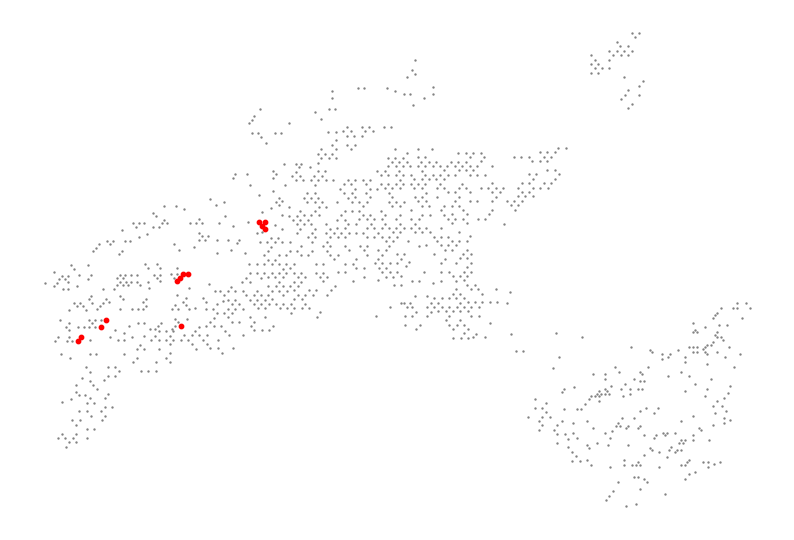

In [532]:
reg_nat_threshold = 0
unesco_threshold = 300
housing_threshold = 400
transmission_threshold = 10000

gdf = gdf_vaud_clusters
gdf = gdf.reset_index(drop=True)

# Set up the solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# Define decision variables
x = {i: solver.IntVar(0, 1, '') for i in range(len(gdf))}

# Total production should be 1.2 TWh/yha * GDP ratio or more for all constraints
solver.Add(sum(x[i] * gdf.prod_MW[i] for i in range(len(gdf))) >= 1200000*ratio_gdp)

for i in range(len(gdf)):
	if gdf.DIST_UNE_N[i] < unesco_threshold or gdf.DIST_UNE_K[i] < unesco_threshold:
		solver.Add(x[i] == 0)
	if gdf.DIST_REG_N[i] < reg_nat_threshold or gdf.DIST_NATPA[i] < reg_nat_threshold:
				solver.Add(x[i] == 0)
	if gdf.DIST_HZ[i] < housing_threshold:
				solver.Add(x[i] == 0)
	if gdf.DIST_PL[i] > transmission_threshold:
				solver.Add(x[i] == 0)
	if gdf.FFF[i] == 1:
				solver.Add(x[i] == 0)

# Define the objective function: Minimize the number of wind turbines
solver.Minimize(solver.Sum(x[i] for i in range(len(gdf))))

status = solver.Solve()
if status == pywraplp.Solver.OPTIMAL:

	selected_locations = [gdf.iloc[i]['geometry']
							for i in range(len(gdf)) if x[i].solution_value() > 0]
	
	# create a new GeoDataFrame from selected locations
	selected_gdf = gpd.GeoDataFrame(geometry=selected_locations)

	# plot the selected locations on the map
	ax = gdf_vaud.plot(color='grey', markersize=0.5, figsize=(10, 10))
	selected_gdf.plot(ax=ax, marker='o', color='red', markersize=10)

	# removing axis on the plot
	ax.axis('off')

	num_turbines = len(selected_locations)
	total_output = sum(gdf.iloc[i]['prod_MW'] for i in range(
		len(gdf)) if x[i].solution_value() > 0)
	print('Optimization results')
	print('------------------------------------------')
	print(f'Number of turbines needed: {num_turbines}')
	print(f'Energy output: {np.round(total_output/1000000,4)} TWh/y')
	plt.show()

else:
	print('The problem does not have an optimal solution.')




### Sort clusters from highest power output

In [533]:
# Sort clusters by total power output
cluster_outputs = {cluster_id: gdf_clustered[gdf_clustered['cluster'] == cluster_id]['prod_MW'].sum() for cluster_id in gdf['cluster'].unique() if cluster_id != -1}
sorted_clusters = sorted(cluster_outputs.items(), key=lambda item: item[1], reverse=True)

# Initialize total power output and selected clusters
total_output = 0
selected_clusters = []

# Iteratively add clusters until the power output constraint is met
for cluster_id, output in sorted_clusters:
    if total_output + output > 1.21*(10**6):
        continue
    total_output += output
    selected_clusters.append(cluster_id)

print('Total power output:', total_output)
print('Selected clusters:', selected_clusters)
print('Number of clusters needed: ', len(selected_clusters))


print('Total power output:', total_output)


Total power output: 399124.4777099356
Selected clusters: [33, 25, 9, 21, 11, 40, 27, 39, 6, 29, 23, 35, 28, 22, 19, 32, 26, 15, 0, 37, 38, 13, 18, 14, 5, 3, 8, 31, 20, 1, 12, 16, 4, 41, 7, 10, 36, 2, 30, 34, 24, 17]
Number of clusters needed:  42
Total power output: 399124.4777099356


## 6 Case Study: Maximizing the energy output per visible hectare

### Problem Formulation 

The problem aims maximize the energy density (ENER_DENS) while ensuring a total power production of at least 1.2 TWh/year. We will also include a trade-off represented by lambda, to cap the total amount of wind turbines.

### Decision Variables 

Let's denote the binary decision variables with the letter $x$. Each $x_{i}$ represents whether a wind turbine is placed at location $i$ or not. If a wind turbine is placed at location $i$, $x_{i}$ will be 1, otherwise, it will be 0.

$x_{i} \in \{0, 1\}$ for each $i \in I$, where $I$ is the set of all locations.

### Constraints 



1. **Total energy output should be equal or more than 1.2TWh/y times the share of the GDP in Vaud.**
   
   $\sum_{i \in I} x_{i} * p_{i} \geq 1200000 * GPD_{share}$

2. **Distance to Regional and National natural park should be more or equal to 2000m (2km)**
   
   If $d_{NAT,i} < 2000$, then $x_{i} = 0$

3. Distance to Unesco heritage area should be more or equal to 2000m (2km)
   
   If $d_{UNE,i} < 2000$, then $x_{i} = 0$

4. **Distance to housing zone area should be more or equal to 650m**
   
   If $d_{HZ,i} < 650$, then $x_{i} = 0$

5. **Distance to transmission should be less or equal to 2000m (2km)**
   
   If $d_{PL,i} > 2000$, then $x_{i} = 0$

6. **Avoid crop rotation area**
   
   If $f_{i} = 1$, then $x_{i} = 0$

### Objective Function 

The objective is to minimize the number of wind turbines and maximize the energy density (ENER_DENS). If $d_{i}$ represents the energy density at location $i$, and $λ$ represents the trade-off weight, this can be mathematically represented as:

$Maximize: \sum_{i \in I} (λ*d_{i}-(1-λ)*1) * x_{i}$

In our case, we can set $λ$ to be different values, to display the trade-off between the two objectives. For the code below we have chosen the following:

$λ \in \{0.5, 0.75, 0.9, 1\}$

### Further intuition

To further explain our objective, we can use two different cases ( $λ = [0, 1]$ )to show what happens to our objective function.

1. λ = 0
   
   $Maximize: \sum_{i \in I} (0*d_{i}-(1-0)*1) * x_{i}$
   
   $Maximize: \sum_{i \in I} (0*d_{i}-(1)*1) * x_{i}$
   
   $Maximize: \sum_{i \in I} (-1) * x_{i}$
   
   $Maximize: \sum_{i \in I} -x_{i}$

As we are trying to maximize a negative number, this means that we are trying to minimize the number of wind turbines. This is the same as the objective function in the previous section. 

2. λ = 1

   $Maximize: \sum_{i \in I} (1*d_{i}-(1-1)*1) * x_{i}$
   
   $Maximize: \sum_{i \in I} (1*d_{i}-(0)*1) * x_{i}$
   
   $Maximize: \sum_{i \in I} (d_{i}) * x_{i}$

Now, we see that the objective function is trying to maximize the energy density. With no constraints, this will basically open all the wind turbines in the canton of Vaud.


In conclusion, an higher lambda (λ) will put greater emphasis on energy density, while a lower lambda (λ) will put greater emphasis on minimizing the number of wind turbines.


### Solution 

The solution of the problem is a vector $x$ that satisfies the constraint and maximizes the objective function. If there is no such vector, the problem does not have an optimal solution.

New objective function for individual turbines



Optimizing for trade-offs = [0.4, 0.5, 0.6, 0.7, 0.75, 0.9, 1]

Optimization results for trade-off = 0.4
------------------------------------------
Number of wind turbines needed: 11
Total energy output: 0.0967 TWh/y
Total energy density: 5.0 MWh/yha


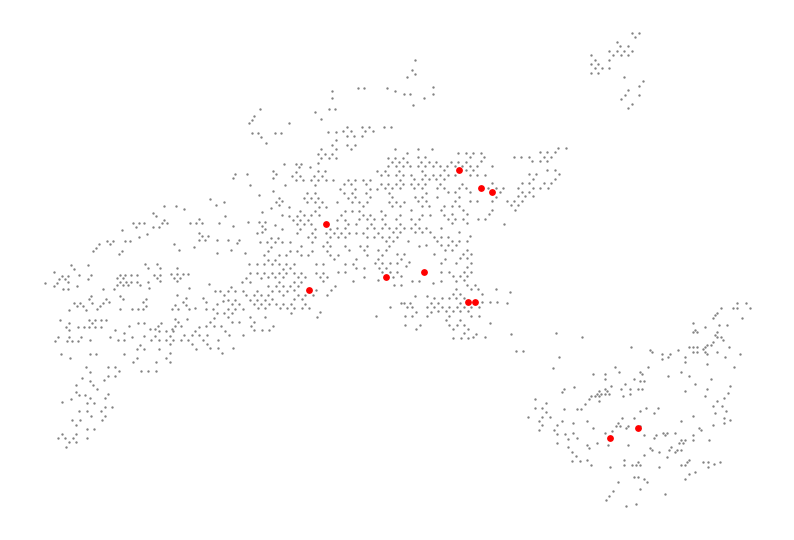


Optimization results for trade-off = 0.5
------------------------------------------
Number of wind turbines needed: 12
Total energy output: 0.0975 TWh/y
Total energy density: 6.0 MWh/yha


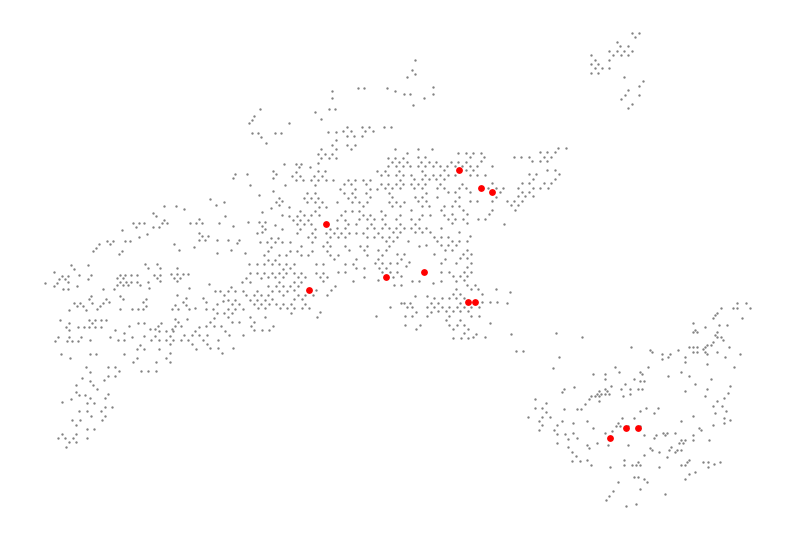


Optimization results for trade-off = 0.6
------------------------------------------
Number of wind turbines needed: 14
Total energy output: 0.0982 TWh/y
Total energy density: 8.0 MWh/yha


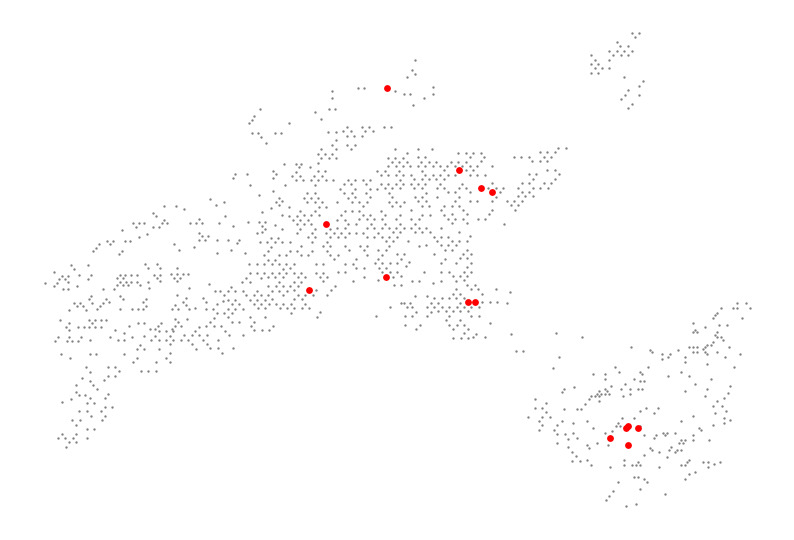


Optimization results for trade-off = 0.7
------------------------------------------
Number of wind turbines needed: 14
Total energy output: 0.0982 TWh/y
Total energy density: 8.0 MWh/yha


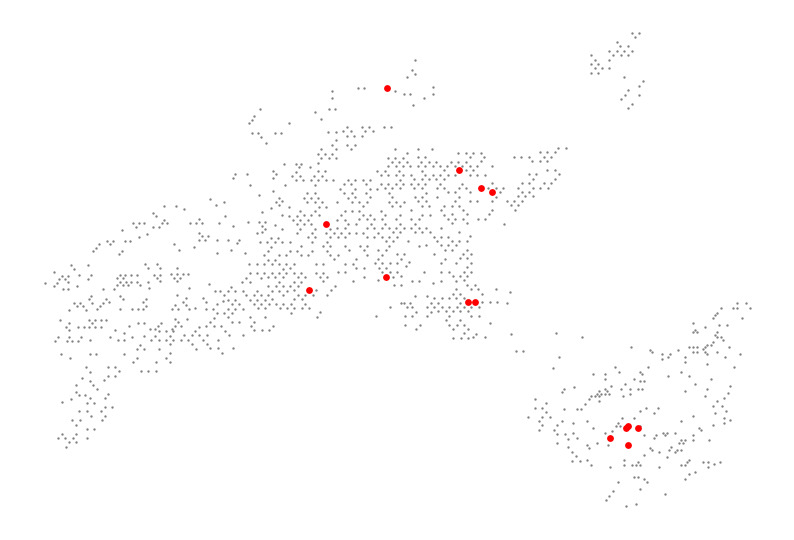


Optimization results for trade-off = 0.75
------------------------------------------
Number of wind turbines needed: 15
Total energy output: 0.1006 TWh/y
Total energy density: 8.0 MWh/yha


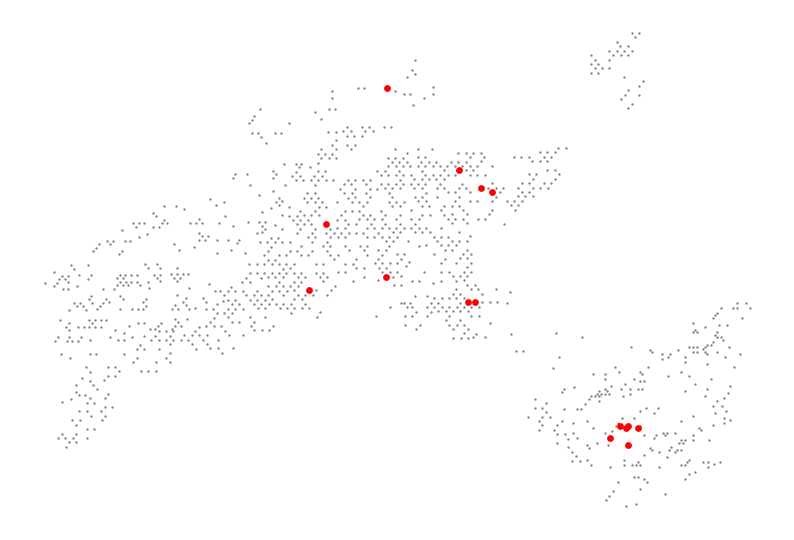


Optimization results for trade-off = 0.9
------------------------------------------
Number of wind turbines needed: 16
Total energy output: 0.1031 TWh/y
Total energy density: 8.0 MWh/yha


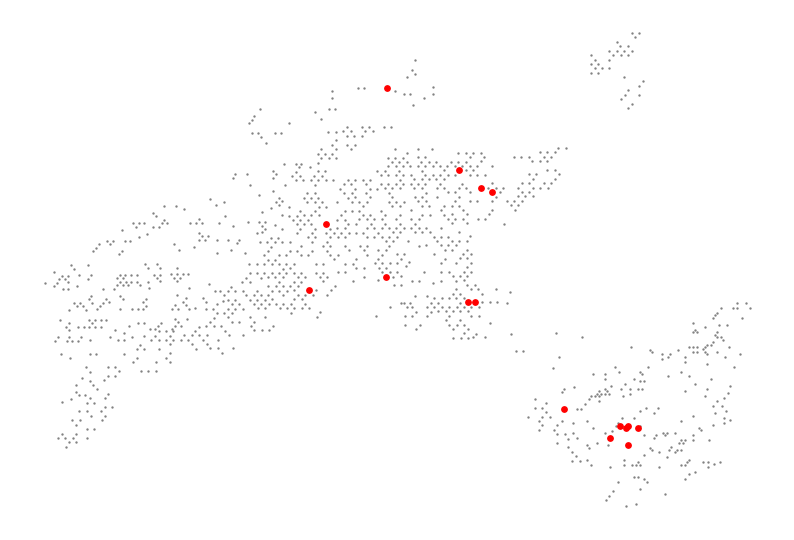


Optimization results for trade-off = 1
------------------------------------------
Number of wind turbines needed: 19
Total energy output: 0.1259 TWh/y
Total energy density: 9.0 MWh/yha


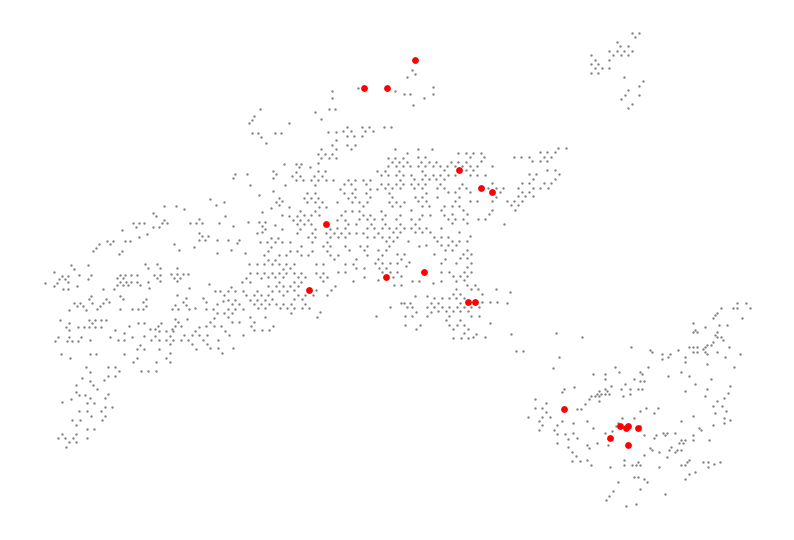

In [610]:
def optimize_wind_turbine_placement_on_enr_dens(gdf, trade_offs):

    reg_nat_threshold = 2000
    unesco_threshold = 2000
    housing_threshold = 650
    transmission_threshold = 2000

    selected_locations = []
    print(f'\n\nOptimizing for trade-offs = {trade_offs}')


    for trade_off in trade_offs:
        print(f'\nOptimization results for trade-off = {trade_off}')
        print('------------------------------------------')

        # 1. Set up the solver
        solver = pywraplp.Solver.CreateSolver('SCIP')
        # 2. Define decision variables
        x = {}
        for i in range(len(gdf)):
            x[i] = solver.IntVar(0, 1, '')

        # 3. Define the constraint : total production should be 1.2 TWh/yha or more
        solver.Add(sum(x[i] * gdf.prod_MW[i] for i in range(len(gdf))) >= 1200000*ratio_gdp)

        for i in range(len(gdf)):
            if gdf.DIST_UNE_N[i] < unesco_threshold or gdf.DIST_UNE_K[i] < unesco_threshold:
                solver.Add(x[i] == 0)
            if gdf.DIST_REG_N[i] < reg_nat_threshold or gdf.DIST_NATPA[i] < reg_nat_threshold:
                solver.Add(x[i] == 0)
            if gdf.DIST_HZ[i] < housing_threshold:
                solver.Add(x[i] == 0)
            if gdf.DIST_PL[i] > transmission_threshold:
                solver.Add(x[i] == 0)
            if gdf.FFF[i] == 1:
                solver.Add(x[i] == 0)

        # 4. Define the objective function
        objective = solver.Objective()
        for i in range(len(gdf)):
            objective.SetCoefficient(x[i], trade_off * gdf.ENER_DENS[i] - (1 - trade_off) * 1)
        objective.SetMaximization()

        status = solver.Solve()

        # 6. Print the solution
        if status == pywraplp.Solver.OPTIMAL:
            selected_locations_enr_dens = []
            total_output = 0
            total_energy_density = 0
            for i in range(len(gdf)):
                if x[i].solution_value() > 0:
                    selected_locations_enr_dens.append(gdf.iloc[i]['geometry'])
                    total_output += gdf.iloc[i]['prod_MW']
                    total_energy_density += gdf.iloc[i]['ENER_DENS']
            print(
                f'Number of wind turbines needed: {len(selected_locations_enr_dens)}')
            print(f'Total energy output: {np.round(total_output/1000000, 4)} TWh/y')
            print(f'Total energy density: {np.round(total_energy_density)} MWh/yha')
            selected_locations_df = gpd.GeoDataFrame(geometry=selected_locations_enr_dens)
            ax = gdf_vaud.plot(color='grey', markersize=0.5, figsize=(10, 10))
            selected_locations_df.plot(ax=ax, marker='o', color='red', markersize=15)
            # removing axis on the plot
            ax.axis('off')
            plt.show()
            selected_locations.append(selected_locations_enr_dens)
        else:
            print('The problem does not have an optimal solution.')
    return selected_locations

trade_offs = [0.4, 0.5, 0.6, 0.7, 0.75, 0.9, 1]

selected_locations_enr_dens_vaud = optimize_wind_turbine_placement_on_enr_dens(gdf_vaud, trade_offs=trade_offs)




Optimizing for trade-offs = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

Optimization results for trade-off = 0
------------------------------------------
Number of wind turbines needed: 10
Total energy output: 0.1 TWh/y
Total energy density: 3.0 MWh/yha

Optimization results for trade-off = 0.1
------------------------------------------
Number of wind turbines needed: 10
Total energy output: 0.0967 TWh/y
Total energy density: 3.0 MWh/yha

Optimization results for trade-off = 0.2
------------------------------------------
Number of wind turbines needed: 10
Total energy output: 0.0967 TWh/y
Total energy density: 3.0 MWh/yha

Optimization results for trade-off = 0.3
------------------------------------------
Number of wind turbines needed: 10
Total energy output: 0.0967 TWh/y
Total energy density: 3.0 MWh/yha

Optimization results for trade-off = 0.4
------------------------------------------
Number of wind turbines needed: 11
Total energy output: 0.0967 TWh/y
Total energy dens

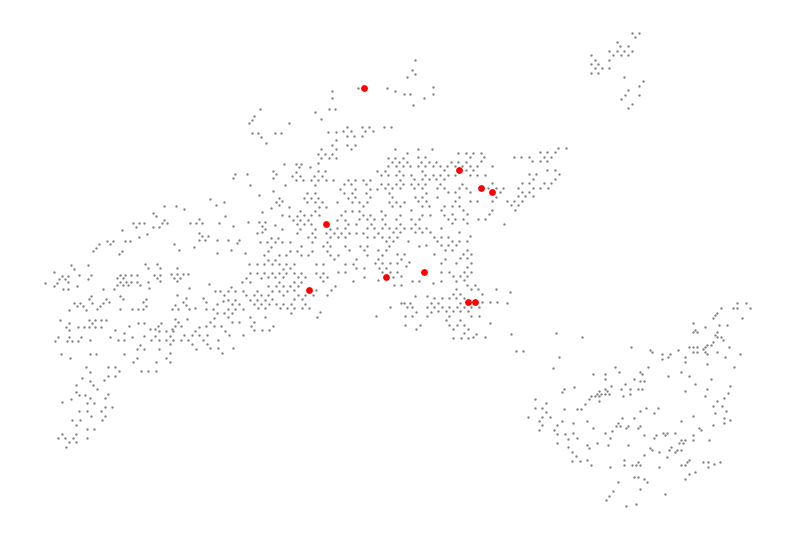

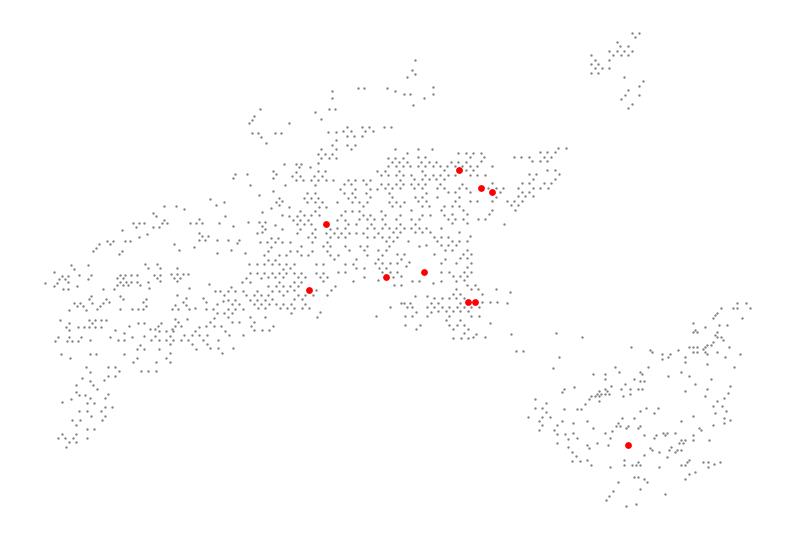

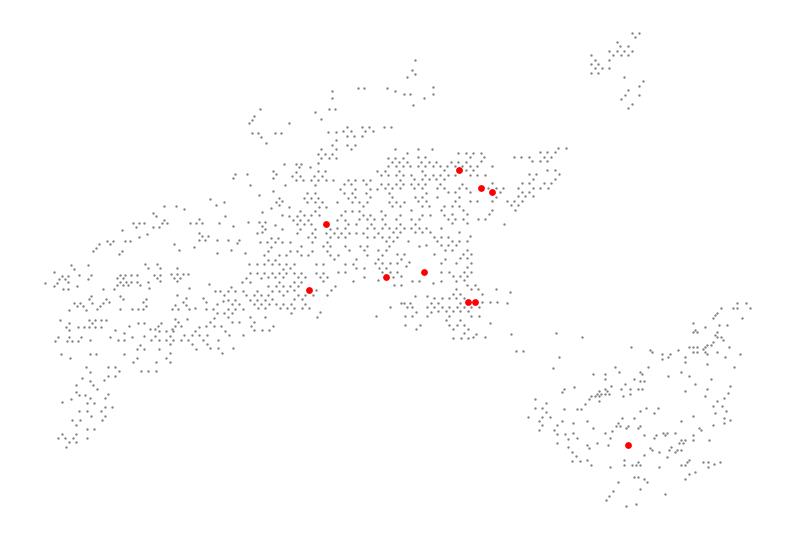

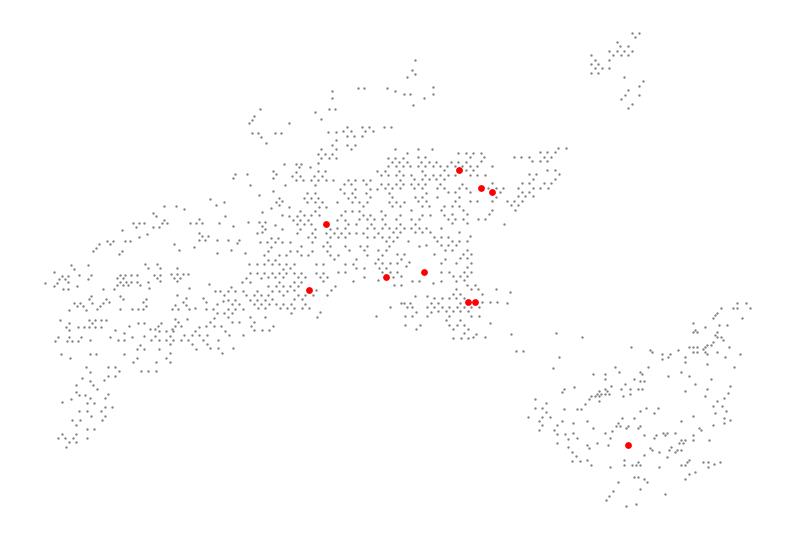

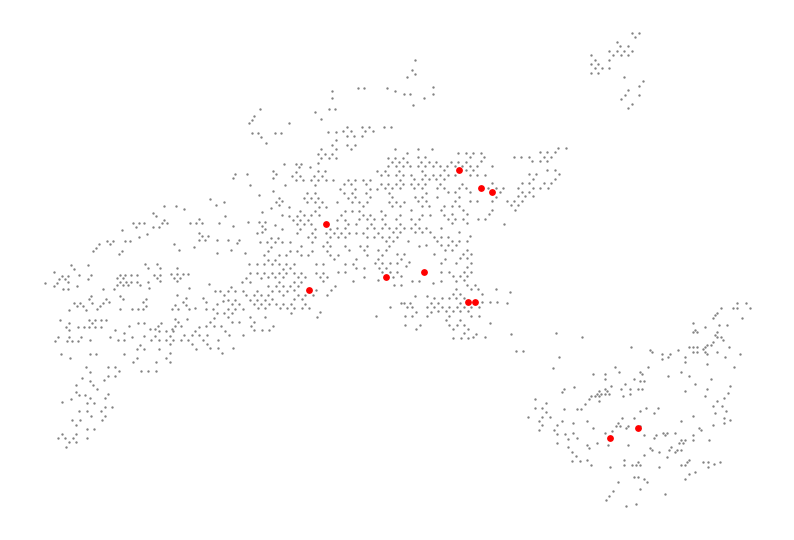

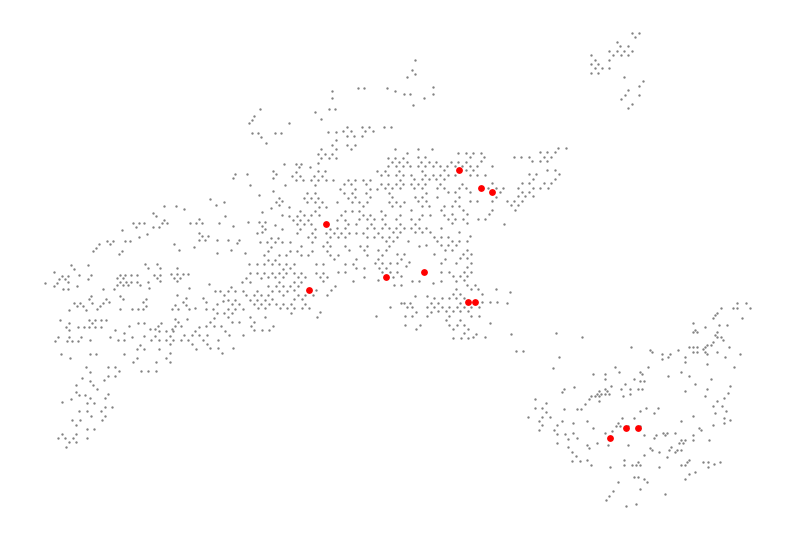

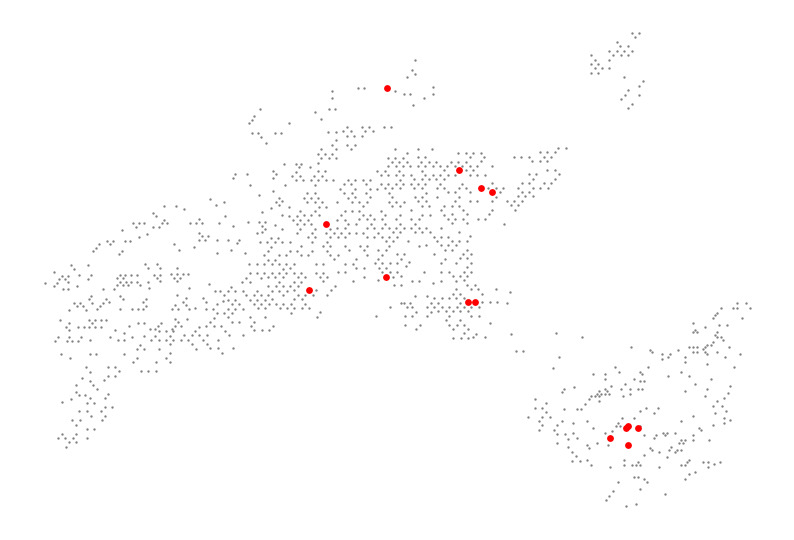

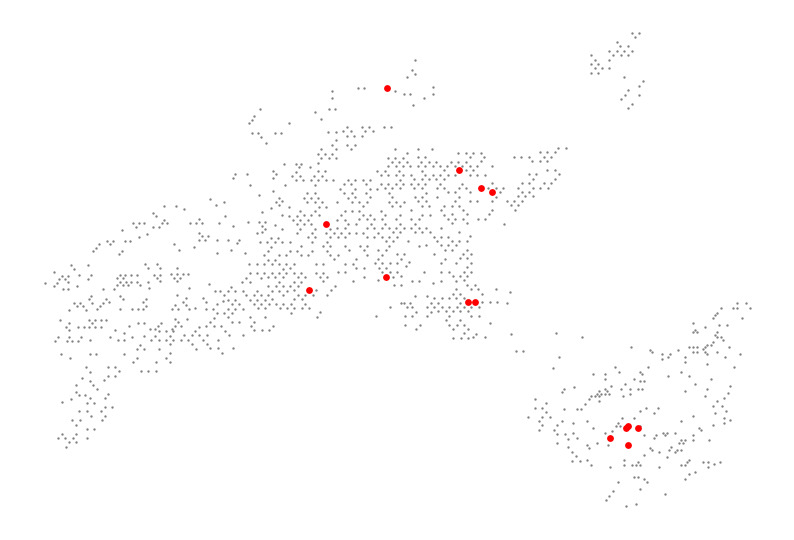

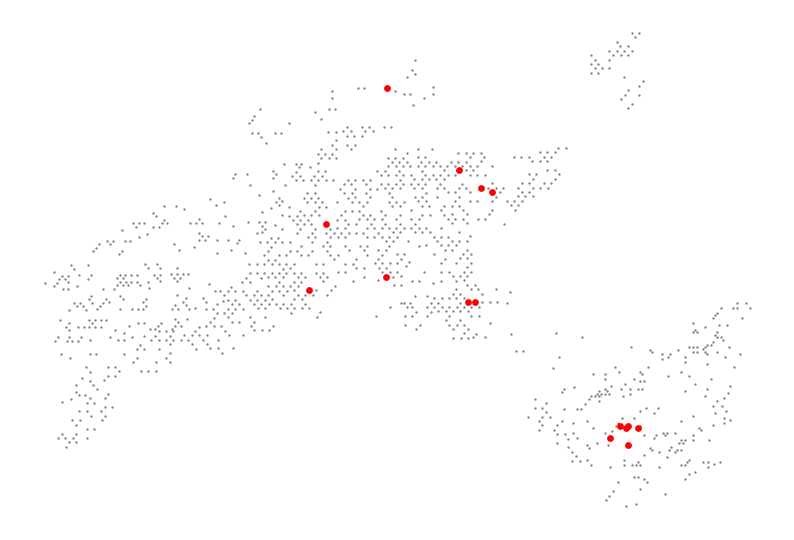

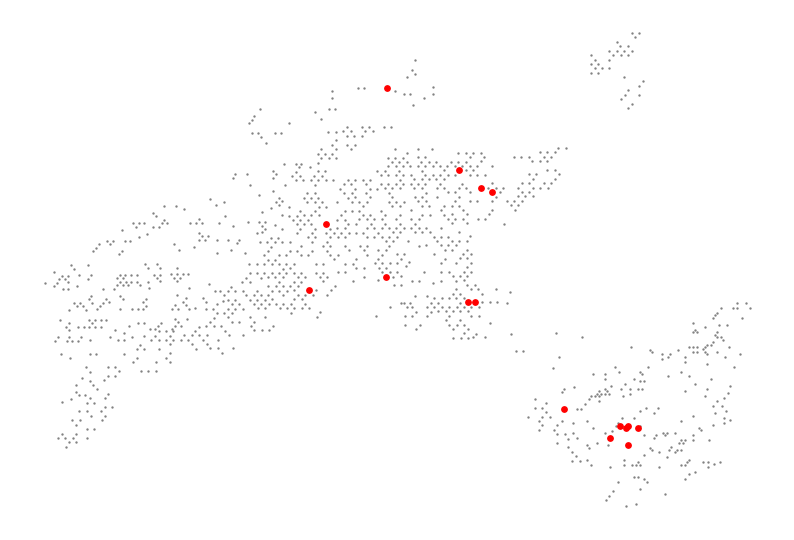

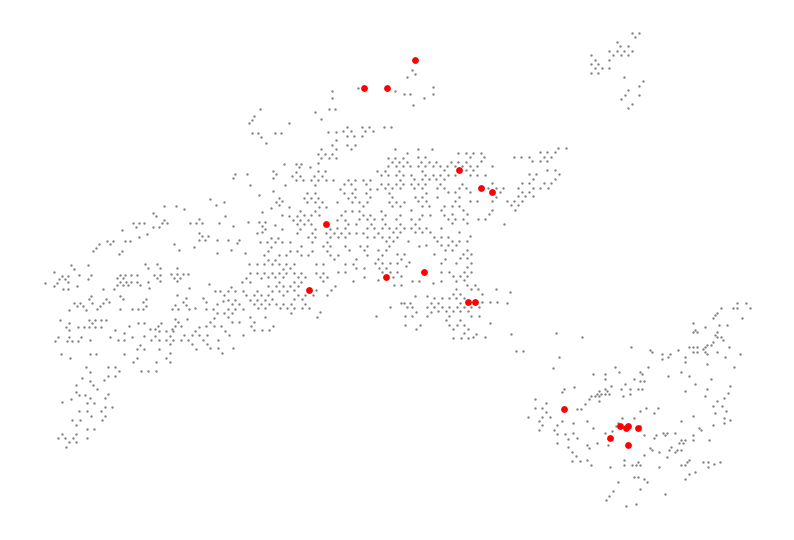

In [604]:
# Creating a list of trade-offs for the animation

trade_offs_for_animation = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
selected_locations_for_animation = optimize_wind_turbine_placement_on_enr_dens(gdf_vaud, trade_offs=trade_offs_for_animation)

MovieWriter Pillow unavailable; using Pillow instead.


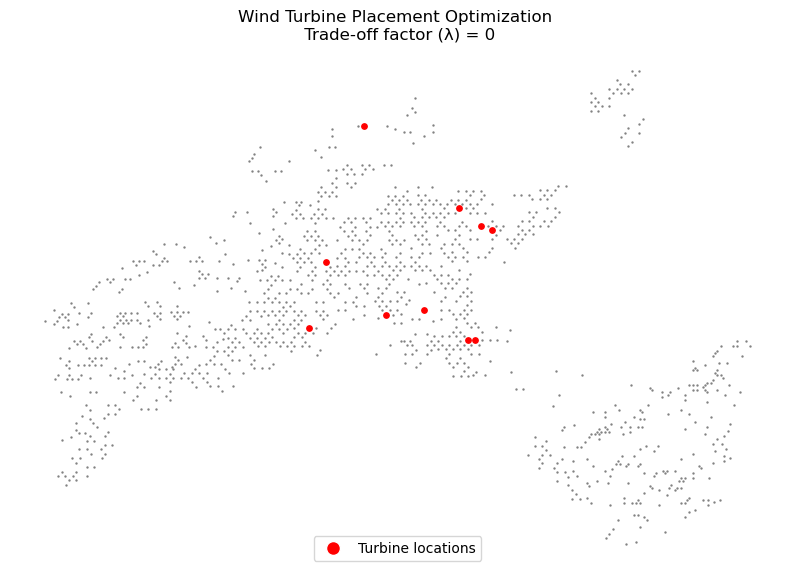

In [607]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

# Importing 2D plotting library
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, 10))

def update(num):
    ax.clear()
    base_map = gdf_vaud.plot(color='grey', markersize=0.5, ax=ax)
    locs = gpd.GeoDataFrame(geometry=selected_locations_for_animation[num])  # Convert to GeoDataFrame
    locs.plot(ax=base_map, marker='o', color='red', markersize=15)
    
    # Add title
    ax.set_title(f'Wind Turbine Placement Optimization \n Trade-off factor (λ) = {trade_offs_for_animation[num]}')

    # Plotting the legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Turbine locations',
                                markerfacecolor='r', markersize=10)]
    ax.legend(handles=legend_elements, loc='lower center')
    
    # Remove axis
    ax.axis('off')

ani = animation.FuncAnimation(fig, update, frames=len(selected_locations_for_animation), repeat=True, interval=2000)

ani.save('./output/wind_turbine_placement.gif', writer='Pillow', fps=1)
#plt.show()


## Watermark for programming environment

In [535]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,matplotlib,seaborn,dbfread,ortools


The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.12.0

numpy     : 1.23.5
pandas    : 1.4.3
matplotlib: 3.7.1
seaborn   : 0.12.2
dbfread   : 2.0.7
ortools   : 9.6.2534

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

